In [1]:
import numpy as np

# Generic replay buffer for standard gym tasks
class StandardBuffer(object):
    def __init__(self, state_shape, buffer_size, device):
        self.max_size = int(buffer_size)
        self.device = device
        self.ptr = 0
        self.crt_size = 0

        self.state = np.zeros((self.max_size, *state_shape))
        self.action = np.zeros((self.max_size, 1))
        self.next_state = np.zeros((self.max_size, *state_shape))
        # self.next_state = np.array(self.state)
        self.reward = np.zeros((self.max_size, 1))
        self.not_done = np.zeros((self.max_size, 1))

    def add(self, state, action, next_state, reward, done):
        self.state[self.ptr] = state
        self.action[self.ptr] = action
        self.next_state[self.ptr] = next_state
        self.reward[self.ptr] = reward
        self.not_done[self.ptr] = 1. - done

        self.ptr = (self.ptr + 1) % self.max_size
        self.crt_size = min(self.crt_size + 1, self.max_size)

    def sample(self, batch_size=32):
        ind = np.random.randint(0, self.crt_size, size=batch_size)
        return (
            torch.FloatTensor(self.state[ind]).to(self.device),
            torch.LongTensor(self.action[ind]).to(self.device),
            torch.FloatTensor(self.next_state[ind]).to(self.device),
            torch.FloatTensor(self.reward[ind]).to(self.device),
            torch.FloatTensor(self.not_done[ind]).to(self.device),
        )

    def save(self, save_folder):
        np.save(f"{save_folder}_state.npy", self.state[:self.crt_size])
        np.save(f"{save_folder}_action.npy", self.action[:self.crt_size])
        np.save(f"{save_folder}_next_state.npy", self.next_state[:self.crt_size])
        np.save(f"{save_folder}_reward.npy", self.reward[:self.crt_size])
        np.save(f"{save_folder}_not_done.npy", self.not_done[:self.crt_size])
        np.save(f"{save_folder}_ptr.npy", self.ptr)

    def load(self, save_folder, size=-1):
        reward_buffer = np.load(f"{save_folder}_reward.npy")
        # Adjust crt_size if we're using a custom size
        size = min(int(size), self.max_size) if size > 0 else self.max_size
        self.crt_size = min(reward_buffer.shape[0], size)

        self.state[:self.crt_size] = np.load(f"{save_folder}_state.npy")[:self.crt_size]
        self.action[:self.crt_size] = np.load(f"{save_folder}_action.npy")[:self.crt_size]
        self.next_state[:self.crt_size] = np.load(f"{save_folder}_next_state.npy")[:self.crt_size]
        self.reward[:self.crt_size] = reward_buffer[:self.crt_size]
        self.not_done[:self.crt_size] = np.load(f"{save_folder}_not_done.npy")[:self.crt_size]
        print(f"Replay Buffer loaded with {self.crt_size} elements.")

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import copy
from tqdm import tqdm
from dqn import DQN, Phi, Critic, ConvEncoder

class RMS(object):
    """running mean and std """
    def __init__(self, device, epsilon=1e-4, shape=(1,)):
        self.M = torch.zeros(shape).to(device)
        self.S = torch.ones(shape).to(device)
        self.n = epsilon

    def __call__(self, x):
        bs = x.size(0)
        delta = torch.mean(x, dim=0) - self.M
        new_M = self.M + delta * bs / (self.n + bs)
        new_S = (self.S * self.n + torch.var(x, dim=0) * bs +
                 torch.square(delta) * self.n * bs /
                 (self.n + bs)) / (self.n + bs)

        self.M = new_M
        self.S = new_S
        self.n += bs

        return self.M, self.S
    
class PBE(object):
    """particle-based entropy based on knn normalized by running mean """
    def __init__(self, rms, knn_clip, knn_k, knn_avg, knn_rms, device):
        self.rms = rms
        self.knn_rms = knn_rms
        self.knn_k = knn_k
        self.knn_avg = knn_avg
        self.knn_clip = knn_clip
        self.device = device

    def __call__(self, rep):
        source = target = rep
        b1, b2 = source.size(0), target.size(0)
        # (b1, 1, c) - (1, b2, c) -> (b1, 1, c) - (1, b2, c) -> (b1, b2, c) -> (b1, b2)
        sim_matrix = torch.norm(source[:, None, :].view(b1, 1, -1) -
                                target[None, :, :].view(1, b2, -1),
                                dim=-1,
                                p=2)
        reward, _ = sim_matrix.topk(self.knn_k,
                                    dim=1,
                                    largest=False,
                                    sorted=True)  # (b1, k)
        if not self.knn_avg:  # only keep k-th nearest neighbor
            reward = reward[:, -1]
            reward = reward.reshape(-1, 1)  # (b1, 1)
            reward /= self.rms(reward)[0] if self.knn_rms else 1.0
            reward = torch.maximum(
                reward - self.knn_clip,
                torch.zeros_like(reward).to(self.device)
            ) if self.knn_clip >= 0.0 else reward  # (b1, 1)
        else:  # average over all k nearest neighbors
            reward = reward.reshape(-1, 1)  # (b1 * k, 1)
            reward /= self.rms(reward)[0] if self.knn_rms else 1.0
            reward = torch.maximum(
                reward - self.knn_clip,
                torch.zeros_like(reward).to(
                    self.device)) if self.knn_clip >= 0.0 else reward
            reward = reward.reshape((b1, self.knn_k))  # (b1, k)
            reward = reward.mean(dim=1, keepdim=True)  # (b1, 1)
        reward = torch.log(reward + 1.0)
        return reward
    
class IdentityPhi(nn.Module):
    def __init__(
        self,
        latent_dim,
        hidden_dim,
        sf_dim,
    ):
        super().__init__()
        self.fc1 = nn.Linear(1, 1)
    
    def forward(self, latent, norm=True):
        return F.normalize(latent, dim=-1)
    
class IdentityEncoder(nn.Module):
    def __init__(
        self,
        state_shape,
        latent_dim,
    ):
        super().__init__()
        self.fc1 = nn.Linear(1, 1)
    
    def forward(self, state):
        return state

class GridAPS(DQN):
    def __init__(
        self,
        env,
        conv=True,
        discount=0.99,
        lr_critic=1e-4,
        lr_encoder=1e-4, 
        latent_dim=256,
        hidden_dim=256,
        initial_eps=1,
        end_eps=0.1,
        eval_eps=0.1,
        pretrain_eps=1,
        eps_decay_period=int(2e4),
        target_update_frequency=200,
        double_q=False,
        # the following are variables for APS
        sf_dim=169,
        lr_phi=1e-4,
        lr_task=3e-4,
        update_task_frequency=5,
        knn_k=12,
        knn_rms=True,
        knn_avg=True,
        knn_clip=1e-4,
    ):
        # for APS 
        self.sf_dim = sf_dim
        self.lr_phi = lr_phi
        self.lr_task = lr_task
        self.update_task_frequency = update_task_frequency
        self.knn_k = knn_k
        self.knn_rms = knn_rms
        self.knn_avg = knn_avg
        self.knn_clip = knn_clip
        self.temp_task = None # temp tasks are set through function : set_task
        
        super().__init__(
            env=env,
            conv=conv,
            discount=discount,
            lr_critic=lr_critic,
            lr_encoder=lr_encoder,
            latent_dim=latent_dim,
            hidden_dim=hidden_dim,
            initial_eps=initial_eps,
            end_eps=end_eps,
            eval_eps=eval_eps,
            pretrain_eps=pretrain_eps,
            eps_decay_period=eps_decay_period,
            target_update_frequency=target_update_frequency,
            double_q=double_q,
        )
        
        self.task_loss = []
        
    def _make_alias(self):
        self.SF1 = self.critic.get_SF1
        self.SF = self.critic.get_SFs
        self.SF1_target = self.critic_target.get_SF1
        self.SF_target = self.critic_target.get_SFs
        
        # to get Q's, one need 'task' (a k-dim vector)
        self.Q1 = self.critic.get_Q1
        self.Q = self.critic.get_Qs
        self.Q1_target = self.critic_target.get_Q1
        self.Q_target = self.critic_target.get_Qs
        
    def _define_networks(self):
        self.encoder = IndentityEncoder(
            state_shape=self.state_shape,
            latent_dim=self.latent_dim,
        )
        
        self.phi = IdentityPhi(
            latent_dim=self.latent_dim,
            hidden_dim=self.hidden_dim,
            sf_dim=self.sf_dim,
        )

        
        self.critic = Critic(
            latent_dim=self.latent_dim, # input is cat([latent, task])
            hidden_dim=self.hidden_dim, 
            num_actions=self.num_actions,
            sf_dim=self.sf_dim
        )
        self.critic_target = copy.deepcopy(self.critic)
        
        self.RMS = RMS(self.device)
        self.PBE = PBE(
            rms=self.RMS,
            knn_clip=self.knn_clip,
            knn_k=self.knn_k, 
            knn_avg=self.knn_avg, 
            knn_rms=self.knn_rms,
            device=self.device
        )
        
        self.encoder_opt = torch.optim.Adam(self.encoder.parameters(), lr=self.lr_encoder)
        self.phi_opt = torch.optim.Adam(self.phi.parameters(), lr=self.lr_phi)
        self.critic_opt = torch.optim.Adam(self.critic.parameters(), lr=self.lr_critic)
        
        self.task_learned = True
        self.task = torch.ones((1, self.sf_dim), requires_grad=True, device=self.device) # task is only for RL phase (supervised learning phase)
        self.task_opt = torch.optim.Adam([self.task], lr=self.lr_task)
        
    def intrinsic_reward(self, task, next_latent):
        # maxent reward
        with torch.no_grad():
            state_representation = self.phi(next_latent, norm=False)
        bonus = self.PBE(state_representation)
        ent_bonus = bonus.view(-1, 1)

        # successor feature reward
        state_representation = state_representation / torch.norm(state_representation, dim=1, keepdim=True)
        sf_reward = torch.einsum("bi,bi->b", task, state_representation).reshape(-1, 1)

        return ent_bonus, sf_reward
    
    def maybe_set_task(self, fine_tune):
        if fine_tune:
            return self.task
        elif (self.iterations + 1) % self.update_task_frequency:
            return self.set_task()
        
        return self.temp_task
    
    def set_task(self):
        task = torch.randn(self.sf_dim).to(self.device)
        task = task / torch.norm(task)
        self.temp_task = task
        return task
    
    def visualize_representation(self, state):
        # state needs to be a numpy array
        state = torch.from_numpy(state).unsqueeze(0).to(self.device)
        out = self.phi(self.encoder(state))
        return out.cpu().data.numpy()
    
    def make_replay_buffer(self, buffer_size=int(3e5)):
        return StandardBuffer(self.state_shape, buffer_size, self.device)
        
    def select_action(self, state, task, eval=False, pretrain=True):
        # this function affects evaluation funciton
        if eval: # if eval, we don't care if we are pretraining or not
            eps = self.eval_eps
        elif pretrain: # if pretrain, we use pretrain eps
            eps = self.pretrain_eps
        else:
            eps = max(self.slope * self.iterations + self.initial_eps, self.end_eps)

        # Select action according to policy with probability (1-eps)
        # otherwise, select random action
        if np.random.uniform(0,1) > eps:
            with torch.no_grad():
                state = torch.FloatTensor(state).reshape(self.state_shape).unsqueeze(0).to(self.device)                    
                if type(task) == np.ndarray:
                    task = torch.from_numpy(task).to(self.device)
                task = task.float().view(1, task.shape[-1])
                
                latent = self.encoder(state)
                
                # cat latent and task for universal successor feature
                # latent = torch.cat([latent, task], dim=1)
                return int(self.Q1(latent, task).argmax(1))
        else:
            return np.random.randint(self.num_actions)
    
    def train(self, replay_buffer, batch_size=128, fine_tune=False):
        state, action, next_state, reward, not_done = replay_buffer.sample(batch_size=batch_size)
        
        latent = self.encoder(state)
        next_latent = self.encoder(next_state)
        task = self.task.repeat(batch_size, 1)
        
        # calculate the adjusted reward
        if fine_tune:
            reward = reward # even when we are finetuning, use the task got from the replay_buffer
            # task = self.task.repeat(batch_size, 1) # use the regressed task
        else:
            with torch.no_grad():
                ent_bonus, sf_reward = self.intrinsic_reward(task, next_latent)
                aps_reward = ent_bonus + sf_reward
                reward = aps_reward
            # calculte Phi-loss
            phi_loss = - torch.einsum("bi,bi->b", self.phi(next_latent), task).mean()
            # update Phi and Encoder
            self.encoder_opt.zero_grad()
            self.phi_opt.zero_grad()
            phi_loss.backward()
            self.encoder_opt.step()
            self.phi_opt.step()
        
        
        # cat latent and task, for universal SF approximator
        # we don't update encoder based on Q-loss
        # latent = torch.cat([latent, task], dim=1).detach()
        # next_latent = torch.cat([next_latent, task], dim=1).detach()
        
        # calculate Q-loss
        with torch.no_grad():
            next_action = self.Q1(next_latent, task).argmax(1, keepdim=True)
            if self.double_q:
                target_Q1, target_Q2 = self.Q_target(next_latent, task)
                target_Q1, target_Q2 = (
                    target_Q1.gather(1, next_action).view(-1, 1),
                    target_Q2.gather(1, next_action).view(-1, 1)
                )
                target_Q = torch.min(target_Q1, target_Q2)
            else:
                target_Q = self.critic_target.get_SF1(next_state)[range(state.shape[0]), next_action.reshape(-1).long()]
            
            # print(f'reward : {reward}, not_done : {not_done}, next_action :{next_action}, target_Q : {target_Q}')
            target_Q = state + not_done * self.discount * target_Q
            
        
        if self.double_q:
            Q1, Q2 = self.Q(latent, task)
            Q1, Q2 = (
                Q1.gather(1, action).view(-1, 1),
                Q2.gather(1, action).view(-1, 1)
            )
            
            Q_loss = F.mse_loss(Q1, target_Q) + F.mse_loss(Q2, target_Q)
        else:
            Q = self.critic.get_SF1(latent)[range(state.shape[0]), action.reshape(-1).long()]
            Q_loss = F.mse_loss(Q, target_Q)
        
        # update Q-networks
        # print(f'Q-loss : {Q_loss}, Q : {Q}, Q_target : {target_Q}')
        # print(Q_loss.mean())
        self.critic_opt.zero_grad()
        Q_loss.backward()
        self.critic_opt.step()
        
        # train the task
        # self.regress_task(replay_buffer, 256, 1)
        # self.maybe_regress_task(replay_buffer, 256, 1)
        self.task_loss.append(self.regress_task(replay_buffer, 256, 1))
        
        # update target network
        self.copy_target_update()
        
    def maybe_regress_task(self, replay_buffer, batch_size, epoch_size=1):
        if replay_buffer.crt_size > 4096 and self.iterations % self.update_task_frequency == 0:
            return self.regress_task(replay_buffer, batch_size, epoch_size)
        
    def regress_task(self, replay_buffer, batch_size=32, epoch_size=1):
        # there are two options, one is using gradient descent, the other is using torch.linalg.lstsq
        self.task_learned = True
        for epoch in range(epoch_size):
            state, action, next_state, reward, *_ = replay_buffer.sample(batch_size=batch_size)
            with torch.no_grad():
                next_latent = self.encoder(next_state)
                # next_latent = self.encoder(state)
                representation = self.phi(next_latent)
                
            # estimate the reward
            estimated_reward = torch.einsum("bi,bi->b", representation, self.task.repeat(batch_size, 1)) # 256 by 169, 1 by 169
            
            # update the task
            task_loss = F.mse_loss(reward, estimated_reward)
            self.task_opt.zero_grad()
            task_loss.backward()
            self.task_opt.step()
            
        return task_loss.data.cpu().numpy()
                
    def learn(self, replay_buffer, step_size, learning_start=int(1e4), batch_size=32, fine_tune=False, log_freq=int(1e3)):
        if replay_buffer is None:
            replay_buffer = self.make_replay_buffer()
            
        state = self.env.reset()
        episodic_return = 0
        episode_length = 0
        episode_num = 0
        task = self.set_task()
        evaluations = []
        
        for step in tqdm(range(step_size)):
            if fine_tune:
                self.iterations += 1
            # pick action and transit in the env
            task = self.maybe_set_task(fine_tune)
            if step < learning_start:
                action = self.env.action_space.sample()
            else:
                action = self.select_action(state, task, eval=False, pretrain=(not fine_tune))
            next_state, reward, done, info = self.env.step(action)
            
            # add the experience into the buffer
            replay_buffer.add(state, action, next_state, reward, done)
            if replay_buffer.crt_size > learning_start:
                self.train(replay_buffer, batch_size=batch_size, fine_tune=fine_tune)
            
            # update iterative values
            state = next_state
            episodic_return += reward
            episode_length += 1
            
            # maybe evaluate
            if fine_tune and (step + 1) % log_freq == 0:
                evaluations.append(self.evaluate(fine_tune))
            
            # check if the episode ends
            if done:
                if fine_tune:
                    print(f"====== Total T: {step+1} Episode Num: {episode_num+1} Episode_Length T: {episode_length} Return: {episodic_return:.3f} ======")
                episode_num += 1
                state = self.env.reset()
                episodic_return = 0
                episode_length = 0
                
        return evaluations
    
    def evaluate(self, fine_tune, seed=0, eval_episodes=10):
        eval_env = copy.deepcopy(self.env)
        eval_env.seed(seed + 100)

        avg_reward = 0.
        task = self.maybe_set_task(fine_tune)
        for _ in range(eval_episodes):
            state, done = eval_env.reset(), False
            while not done:
                action = self.select_action(np.array(state), task, eval=True)
                state, reward, done, _ = eval_env.step(action)
                avg_reward += reward

        avg_reward /= eval_episodes

        print("---------------------------------------")
        print(f"Evaluation over {eval_episodes} episodes: {avg_reward:.3f}")
        print("---------------------------------------")
        return avg_reward

In [55]:
from fourrooms import FourRooms
env = FourRooms(config=2, layout='4rooms')
aps1 = GridAPS(
    env, 
    conv=False,
    pretrain_eps=0.5,
    eps_decay_period=int(1e4),
    double_q=False,
    sf_dim=169,
    latent_dim=169,
    update_task_frequency=5,
)

ft_rp1 = aps1.make_replay_buffer()
evaluations = aps1.learn(
    ft_rp1,
    step_size=int(2e5),
    learning_start=int(1e3),
    batch_size=32,
    fine_tune=True
)

  0%|          | 0/200000 [00:00<?, ?it/s]

====== Total T: 200 Episode Num: 1 Episode_Length T: 200 Return: -200.000 ======
====== Total T: 400 Episode Num: 2 Episode_Length T: 200 Return: -200.000 ======
====== Total T: 600 Episode Num: 3 Episode_Length T: 200 Return: -200.000 ======
====== Total T: 689 Episode Num: 4 Episode_Length T: 89 Return: -88.000 ======
====== Total T: 889 Episode Num: 5 Episode_Length T: 200 Return: -200.000 ======
====== Total T: 894 Episode Num: 6 Episode_Length T: 5 Return: -4.000 ======


  0%|          | 1000/200000 [00:00<02:33, 1300.46it/s]

---------------------------------------
Evaluation over 10 episodes: -179.800
---------------------------------------


/home/mila/y/yiran.wang/.conda/envs/mujoco_env/lib/python3.7/site-packages/ipykernel_launcher.py:361: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


====== Total T: 1094 Episode Num: 7 Episode_Length T: 200 Return: -200.000 ======


  1%|          | 1315/200000 [00:03<16:02, 206.51it/s] 

====== Total T: 1294 Episode Num: 8 Episode_Length T: 200 Return: -200.000 ======


  1%|          | 1515/200000 [00:05<29:28, 112.23it/s]

====== Total T: 1494 Episode Num: 9 Episode_Length T: 200 Return: -200.000 ======


  1%|          | 1708/200000 [00:07<28:19, 116.69it/s]

====== Total T: 1694 Episode Num: 10 Episode_Length T: 200 Return: -200.000 ======


  1%|          | 1780/200000 [00:07<28:44, 114.94it/s]

====== Total T: 1761 Episode Num: 11 Episode_Length T: 67 Return: -66.000 ======


  1%|          | 1972/200000 [00:09<29:31, 111.76it/s]

====== Total T: 1961 Episode Num: 12 Episode_Length T: 200 Return: -200.000 ======


  1%|          | 2020/200000 [00:10<1:08:14, 48.36it/s]

---------------------------------------
Evaluation over 10 episodes: -163.700
---------------------------------------


  1%|          | 2176/200000 [00:11<28:48, 114.44it/s] 

====== Total T: 2161 Episode Num: 13 Episode_Length T: 200 Return: -200.000 ======
====== Total T: 2174 Episode Num: 14 Episode_Length T: 13 Return: -12.000 ======


  1%|          | 2392/200000 [00:13<29:07, 113.05it/s]

====== Total T: 2374 Episode Num: 15 Episode_Length T: 200 Return: -200.000 ======


  1%|▏         | 2596/200000 [00:15<28:35, 115.09it/s]

====== Total T: 2574 Episode Num: 16 Episode_Length T: 200 Return: -200.000 ======


  1%|▏         | 2793/200000 [00:17<29:58, 109.64it/s]

====== Total T: 2774 Episode Num: 17 Episode_Length T: 200 Return: -200.000 ======


  1%|▏         | 2994/200000 [00:19<30:29, 107.67it/s]

====== Total T: 2974 Episode Num: 18 Episode_Length T: 200 Return: -200.000 ======


  2%|▏         | 3016/200000 [00:20<1:22:05, 40.00it/s]

---------------------------------------
Evaluation over 10 episodes: -200.000
---------------------------------------


  2%|▏         | 3185/200000 [00:21<30:26, 107.78it/s] 

====== Total T: 3174 Episode Num: 19 Episode_Length T: 200 Return: -200.000 ======


  2%|▏         | 3386/200000 [00:23<30:26, 107.62it/s]

====== Total T: 3374 Episode Num: 20 Episode_Length T: 200 Return: -200.000 ======


  2%|▏         | 3595/200000 [00:25<30:16, 108.14it/s]

====== Total T: 3574 Episode Num: 21 Episode_Length T: 200 Return: -200.000 ======
====== Total T: 3592 Episode Num: 22 Episode_Length T: 18 Return: -17.000 ======


  2%|▏         | 3807/200000 [00:27<30:05, 108.67it/s]

====== Total T: 3792 Episode Num: 23 Episode_Length T: 200 Return: -200.000 ======


  2%|▏         | 3989/200000 [00:29<30:09, 108.34it/s]

====== Total T: 3992 Episode Num: 24 Episode_Length T: 200 Return: -200.000 ======


  2%|▏         | 4009/200000 [00:30<1:26:13, 37.88it/s]

---------------------------------------
Evaluation over 10 episodes: -200.000
---------------------------------------


  2%|▏         | 4208/200000 [00:32<30:33, 106.78it/s] 

====== Total T: 4192 Episode Num: 25 Episode_Length T: 200 Return: -200.000 ======
====== Total T: 4195 Episode Num: 26 Episode_Length T: 3 Return: -2.000 ======


  2%|▏         | 4414/200000 [00:34<29:51, 109.20it/s]

====== Total T: 4395 Episode Num: 27 Episode_Length T: 200 Return: -200.000 ======


  2%|▏         | 4616/200000 [00:36<32:05, 101.48it/s]

====== Total T: 4595 Episode Num: 28 Episode_Length T: 200 Return: -200.000 ======


  2%|▏         | 4808/200000 [00:37<30:59, 105.00it/s]

====== Total T: 4795 Episode Num: 29 Episode_Length T: 200 Return: -200.000 ======


  2%|▏         | 4991/200000 [00:39<30:46, 105.59it/s]

====== Total T: 4995 Episode Num: 30 Episode_Length T: 200 Return: -200.000 ======


  3%|▎         | 5013/200000 [00:40<1:20:52, 40.18it/s]

---------------------------------------
Evaluation over 10 episodes: -200.000
---------------------------------------


  3%|▎         | 5215/200000 [00:42<29:57, 108.35it/s] 

====== Total T: 5195 Episode Num: 31 Episode_Length T: 200 Return: -200.000 ======


  3%|▎         | 5415/200000 [00:44<29:15, 110.86it/s]

====== Total T: 5395 Episode Num: 32 Episode_Length T: 200 Return: -200.000 ======


  3%|▎         | 5608/200000 [00:46<29:38, 109.30it/s]

====== Total T: 5595 Episode Num: 33 Episode_Length T: 200 Return: -200.000 ======
====== Total T: 5612 Episode Num: 34 Episode_Length T: 17 Return: -16.000 ======


  3%|▎         | 5722/200000 [00:47<29:48, 108.65it/s]

====== Total T: 5702 Episode Num: 35 Episode_Length T: 90 Return: -89.000 ======


  3%|▎         | 5868/200000 [00:48<29:36, 109.27it/s]

====== Total T: 5848 Episode Num: 36 Episode_Length T: 146 Return: -145.000 ======


  3%|▎         | 6011/200000 [00:50<1:16:54, 42.04it/s]

---------------------------------------
Evaluation over 10 episodes: -178.700
---------------------------------------


  3%|▎         | 6068/200000 [00:51<37:15, 86.76it/s]  

====== Total T: 6048 Episode Num: 37 Episode_Length T: 200 Return: -200.000 ======
====== Total T: 6061 Episode Num: 38 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 6067 Episode Num: 39 Episode_Length T: 6 Return: -5.000 ======


  3%|▎         | 6102/200000 [00:51<32:14, 100.26it/s]

====== Total T: 6083 Episode Num: 40 Episode_Length T: 16 Return: -15.000 ======


  3%|▎         | 6302/200000 [00:53<29:50, 108.18it/s]

====== Total T: 6283 Episode Num: 41 Episode_Length T: 200 Return: -200.000 ======


  3%|▎         | 6391/200000 [00:54<29:45, 108.40it/s]

====== Total T: 6372 Episode Num: 42 Episode_Length T: 89 Return: -88.000 ======


  3%|▎         | 6583/200000 [00:55<29:35, 108.95it/s]

====== Total T: 6572 Episode Num: 43 Episode_Length T: 200 Return: -200.000 ======


  3%|▎         | 6787/200000 [00:57<29:04, 110.78it/s]

====== Total T: 6772 Episode Num: 44 Episode_Length T: 200 Return: -200.000 ======


  3%|▎         | 6986/200000 [00:59<29:32, 108.92it/s]

====== Total T: 6972 Episode Num: 45 Episode_Length T: 200 Return: -200.000 ======


  4%|▎         | 7020/200000 [01:00<1:05:21, 49.21it/s]

---------------------------------------
Evaluation over 10 episodes: -143.100
---------------------------------------
====== Total T: 7006 Episode Num: 46 Episode_Length T: 34 Return: -33.000 ======


  4%|▎         | 7228/200000 [01:02<28:35, 112.39it/s] 

====== Total T: 7206 Episode Num: 47 Episode_Length T: 200 Return: -200.000 ======
====== Total T: 7225 Episode Num: 48 Episode_Length T: 19 Return: -18.000 ======


  4%|▎         | 7443/200000 [01:04<28:42, 111.77it/s]

====== Total T: 7425 Episode Num: 49 Episode_Length T: 200 Return: -200.000 ======


  4%|▍         | 7646/200000 [01:06<28:31, 112.40it/s]

====== Total T: 7625 Episode Num: 50 Episode_Length T: 200 Return: -200.000 ======


  4%|▍         | 7670/200000 [01:06<28:29, 112.53it/s]

====== Total T: 7656 Episode Num: 51 Episode_Length T: 31 Return: -30.000 ======


  4%|▍         | 7718/200000 [01:06<28:45, 111.42it/s]

====== Total T: 7699 Episode Num: 52 Episode_Length T: 43 Return: -42.000 ======


  4%|▍         | 7752/200000 [01:07<30:02, 106.64it/s]

====== Total T: 7735 Episode Num: 53 Episode_Length T: 36 Return: -35.000 ======


  4%|▍         | 7862/200000 [01:08<30:56, 103.47it/s]

====== Total T: 7848 Episode Num: 54 Episode_Length T: 113 Return: -112.000 ======


  4%|▍         | 8016/200000 [01:10<1:06:12, 48.33it/s]

---------------------------------------
Evaluation over 10 episodes: -136.900
---------------------------------------
====== Total T: 8000 Episode Num: 55 Episode_Length T: 152 Return: -151.000 ======


  4%|▍         | 8103/200000 [01:11<32:26, 98.61it/s]  

====== Total T: 8087 Episode Num: 56 Episode_Length T: 87 Return: -86.000 ======
====== Total T: 8100 Episode Num: 57 Episode_Length T: 13 Return: -12.000 ======


  4%|▍         | 8125/200000 [01:11<31:40, 100.97it/s]

====== Total T: 8108 Episode Num: 58 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 8118 Episode Num: 59 Episode_Length T: 10 Return: -9.000 ======


  4%|▍         | 8203/200000 [01:12<29:47, 107.32it/s]

====== Total T: 8188 Episode Num: 60 Episode_Length T: 70 Return: -69.000 ======
====== Total T: 8208 Episode Num: 61 Episode_Length T: 20 Return: -19.000 ======


  4%|▍         | 8247/200000 [01:12<29:44, 107.48it/s]

====== Total T: 8230 Episode Num: 62 Episode_Length T: 22 Return: -21.000 ======


  4%|▍         | 8444/200000 [01:14<28:35, 111.64it/s]

====== Total T: 8430 Episode Num: 63 Episode_Length T: 200 Return: -200.000 ======


  4%|▍         | 8480/200000 [01:14<28:44, 111.04it/s]

====== Total T: 8462 Episode Num: 64 Episode_Length T: 32 Return: -31.000 ======


  4%|▍         | 8504/200000 [01:14<28:40, 111.31it/s]

====== Total T: 8487 Episode Num: 65 Episode_Length T: 25 Return: -24.000 ======
====== Total T: 8503 Episode Num: 66 Episode_Length T: 16 Return: -15.000 ======


  4%|▍         | 8564/200000 [01:15<28:32, 111.79it/s]

====== Total T: 8547 Episode Num: 67 Episode_Length T: 44 Return: -43.000 ======
====== Total T: 8562 Episode Num: 68 Episode_Length T: 15 Return: -14.000 ======


  4%|▍         | 8588/200000 [01:15<28:47, 110.79it/s]

====== Total T: 8576 Episode Num: 69 Episode_Length T: 14 Return: -13.000 ======


  4%|▍         | 8624/200000 [01:15<28:34, 111.64it/s]

====== Total T: 8605 Episode Num: 70 Episode_Length T: 29 Return: -28.000 ======


  4%|▍         | 8780/200000 [01:17<28:42, 111.04it/s]

====== Total T: 8761 Episode Num: 71 Episode_Length T: 156 Return: -155.000 ======


  4%|▍         | 8804/200000 [01:17<28:52, 110.34it/s]

====== Total T: 8789 Episode Num: 72 Episode_Length T: 28 Return: -27.000 ======


  4%|▍         | 8839/200000 [01:17<29:00, 109.85it/s]

====== Total T: 8820 Episode Num: 73 Episode_Length T: 31 Return: -30.000 ======
====== Total T: 8830 Episode Num: 74 Episode_Length T: 10 Return: -9.000 ======


  5%|▍         | 9016/200000 [01:19<35:23, 89.92it/s] 

---------------------------------------
Evaluation over 10 episodes: -29.500
---------------------------------------


  5%|▍         | 9053/200000 [01:19<29:55, 106.37it/s]

====== Total T: 9030 Episode Num: 75 Episode_Length T: 200 Return: -200.000 ======
====== Total T: 9038 Episode Num: 76 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 9050 Episode Num: 77 Episode_Length T: 12 Return: -11.000 ======


  5%|▍         | 9109/200000 [01:20<31:44, 100.22it/s]

====== Total T: 9093 Episode Num: 78 Episode_Length T: 43 Return: -42.000 ======


  5%|▍         | 9131/200000 [01:20<31:26, 101.17it/s]

====== Total T: 9120 Episode Num: 79 Episode_Length T: 27 Return: -26.000 ======
====== Total T: 9138 Episode Num: 80 Episode_Length T: 18 Return: -17.000 ======


  5%|▍         | 9153/200000 [01:20<31:32, 100.83it/s]

====== Total T: 9142 Episode Num: 81 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 9152 Episode Num: 82 Episode_Length T: 10 Return: -9.000 ======


  5%|▍         | 9197/200000 [01:21<31:03, 102.38it/s]

====== Total T: 9185 Episode Num: 83 Episode_Length T: 33 Return: -32.000 ======


  5%|▍         | 9398/200000 [01:23<28:50, 110.14it/s]

====== Total T: 9382 Episode Num: 84 Episode_Length T: 197 Return: -196.000 ======


  5%|▍         | 9565/200000 [01:24<30:52, 102.79it/s]

====== Total T: 9550 Episode Num: 85 Episode_Length T: 168 Return: -167.000 ======
====== Total T: 9568 Episode Num: 86 Episode_Length T: 18 Return: -17.000 ======


  5%|▍         | 9663/200000 [01:25<29:39, 106.98it/s]

====== Total T: 9652 Episode Num: 87 Episode_Length T: 84 Return: -83.000 ======
====== Total T: 9665 Episode Num: 88 Episode_Length T: 13 Return: -12.000 ======


  5%|▍         | 9730/200000 [01:26<29:55, 105.96it/s]

====== Total T: 9715 Episode Num: 89 Episode_Length T: 50 Return: -49.000 ======
====== Total T: 9719 Episode Num: 90 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 9725 Episode Num: 91 Episode_Length T: 6 Return: -5.000 ======


  5%|▍         | 9752/200000 [01:26<29:35, 107.18it/s]

====== Total T: 9739 Episode Num: 92 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 9755 Episode Num: 93 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 9760 Episode Num: 94 Episode_Length T: 5 Return: -4.000 ======


  5%|▍         | 9786/200000 [01:26<29:31, 107.39it/s]

====== Total T: 9774 Episode Num: 95 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 9784 Episode Num: 96 Episode_Length T: 10 Return: -9.000 ======


  5%|▍         | 9819/200000 [01:27<29:12, 108.53it/s]

====== Total T: 9802 Episode Num: 97 Episode_Length T: 18 Return: -17.000 ======


  5%|▍         | 9918/200000 [01:28<30:14, 104.78it/s]

====== Total T: 9908 Episode Num: 98 Episode_Length T: 106 Return: -105.000 ======
====== Total T: 9929 Episode Num: 99 Episode_Length T: 21 Return: -20.000 ======


  5%|▍         | 9984/200000 [01:28<29:51, 106.09it/s]

====== Total T: 9969 Episode Num: 100 Episode_Length T: 40 Return: -39.000 ======
====== Total T: 9973 Episode Num: 101 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 9988 Episode Num: 102 Episode_Length T: 15 Return: -14.000 ======


  5%|▌         | 10018/200000 [01:29<40:55, 77.37it/s]

---------------------------------------
Evaluation over 10 episodes: -44.800
---------------------------------------
====== Total T: 10005 Episode Num: 103 Episode_Length T: 17 Return: -16.000 ======


  5%|▌         | 10076/200000 [01:29<31:03, 101.89it/s]

====== Total T: 10056 Episode Num: 104 Episode_Length T: 51 Return: -50.000 ======
====== Total T: 10060 Episode Num: 105 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 10064 Episode Num: 106 Episode_Length T: 4 Return: -3.000 ======


  5%|▌         | 10109/200000 [01:30<29:58, 105.58it/s]

====== Total T: 10094 Episode Num: 107 Episode_Length T: 30 Return: -29.000 ======


  5%|▌         | 10131/200000 [01:30<30:07, 105.06it/s]

====== Total T: 10116 Episode Num: 108 Episode_Length T: 22 Return: -21.000 ======
====== Total T: 10128 Episode Num: 109 Episode_Length T: 12 Return: -11.000 ======


  5%|▌         | 10186/200000 [01:30<30:59, 102.10it/s]

====== Total T: 10167 Episode Num: 110 Episode_Length T: 39 Return: -38.000 ======
====== Total T: 10174 Episode Num: 111 Episode_Length T: 7 Return: -6.000 ======


  5%|▌         | 10208/200000 [01:31<30:44, 102.90it/s]

====== Total T: 10189 Episode Num: 112 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 10207 Episode Num: 113 Episode_Length T: 18 Return: -17.000 ======


  5%|▌         | 10241/200000 [01:31<30:39, 103.18it/s]

====== Total T: 10223 Episode Num: 114 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 10232 Episode Num: 115 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 10241 Episode Num: 116 Episode_Length T: 9 Return: -8.000 ======


  5%|▌         | 10263/200000 [01:31<30:37, 103.24it/s]

====== Total T: 10247 Episode Num: 117 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 10254 Episode Num: 118 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 10262 Episode Num: 119 Episode_Length T: 8 Return: -7.000 ======


  5%|▌         | 10297/200000 [01:31<29:38, 106.64it/s]

====== Total T: 10278 Episode Num: 120 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 10295 Episode Num: 121 Episode_Length T: 17 Return: -16.000 ======


  5%|▌         | 10353/200000 [01:32<29:02, 108.84it/s]

====== Total T: 10334 Episode Num: 122 Episode_Length T: 39 Return: -38.000 ======


  5%|▌         | 10386/200000 [01:32<29:35, 106.82it/s]

====== Total T: 10367 Episode Num: 123 Episode_Length T: 33 Return: -32.000 ======
====== Total T: 10378 Episode Num: 124 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 10384 Episode Num: 125 Episode_Length T: 6 Return: -5.000 ======


  5%|▌         | 10599/200000 [01:34<29:38, 106.50it/s]

====== Total T: 10584 Episode Num: 126 Episode_Length T: 200 Return: -200.000 ======
====== Total T: 10597 Episode Num: 127 Episode_Length T: 13 Return: -12.000 ======


  5%|▌         | 10809/200000 [01:36<30:09, 104.54it/s]

====== Total T: 10797 Episode Num: 128 Episode_Length T: 200 Return: -200.000 ======
====== Total T: 10805 Episode Num: 129 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 10813 Episode Num: 130 Episode_Length T: 8 Return: -7.000 ======


  5%|▌         | 10842/200000 [01:36<29:34, 106.57it/s]

====== Total T: 10830 Episode Num: 131 Episode_Length T: 17 Return: -16.000 ======


  5%|▌         | 10941/200000 [01:37<29:48, 105.72it/s]

====== Total T: 10923 Episode Num: 132 Episode_Length T: 93 Return: -92.000 ======
====== Total T: 10928 Episode Num: 133 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 10933 Episode Num: 134 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 10939 Episode Num: 135 Episode_Length T: 6 Return: -5.000 ======


  5%|▌         | 10963/200000 [01:38<29:41, 106.12it/s]

====== Total T: 10945 Episode Num: 136 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 10952 Episode Num: 137 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 10961 Episode Num: 138 Episode_Length T: 9 Return: -8.000 ======


  5%|▌         | 10985/200000 [01:38<29:52, 105.46it/s]

====== Total T: 10967 Episode Num: 139 Episode_Length T: 6 Return: -5.000 ======


  6%|▌         | 11018/200000 [01:38<39:34, 79.57it/s] 

---------------------------------------
Evaluation over 10 episodes: -31.000
---------------------------------------


  6%|▌         | 11050/200000 [01:39<33:37, 93.67it/s]

====== Total T: 11036 Episode Num: 140 Episode_Length T: 69 Return: -68.000 ======
====== Total T: 11043 Episode Num: 141 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 11054 Episode Num: 142 Episode_Length T: 11 Return: -10.000 ======


  6%|▌         | 11082/200000 [01:39<32:02, 98.25it/s]

====== Total T: 11065 Episode Num: 143 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 11076 Episode Num: 144 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 11082 Episode Num: 145 Episode_Length T: 6 Return: -5.000 ======


  6%|▌         | 11103/200000 [01:39<32:16, 97.55it/s]

====== Total T: 11088 Episode Num: 146 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 11100 Episode Num: 147 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 11106 Episode Num: 148 Episode_Length T: 6 Return: -5.000 ======


  6%|▌         | 11123/200000 [01:39<32:07, 97.99it/s]

====== Total T: 11110 Episode Num: 149 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 11124 Episode Num: 150 Episode_Length T: 14 Return: -13.000 ======


  6%|▌         | 11145/200000 [01:40<31:37, 99.52it/s]

====== Total T: 11131 Episode Num: 151 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 11136 Episode Num: 152 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 11140 Episode Num: 153 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 11144 Episode Num: 154 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 11150 Episode Num: 155 Episode_Length T: 6 Return: -5.000 ======


  6%|▌         | 11178/200000 [01:40<30:34, 102.92it/s]

====== Total T: 11158 Episode Num: 156 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 11163 Episode Num: 157 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 11178 Episode Num: 158 Episode_Length T: 15 Return: -14.000 ======


  6%|▌         | 11200/200000 [01:40<30:20, 103.71it/s]

====== Total T: 11188 Episode Num: 159 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 11201 Episode Num: 160 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 11208 Episode Num: 161 Episode_Length T: 7 Return: -6.000 ======


  6%|▌         | 11234/200000 [01:40<29:39, 106.10it/s]

====== Total T: 11219 Episode Num: 162 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 11231 Episode Num: 163 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 11236 Episode Num: 164 Episode_Length T: 5 Return: -4.000 ======


  6%|▌         | 11256/200000 [01:41<29:28, 106.74it/s]

====== Total T: 11244 Episode Num: 165 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 11249 Episode Num: 166 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 11262 Episode Num: 167 Episode_Length T: 13 Return: -12.000 ======


  6%|▌         | 11289/200000 [01:41<29:29, 106.63it/s]

====== Total T: 11273 Episode Num: 168 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 11282 Episode Num: 169 Episode_Length T: 9 Return: -8.000 ======


  6%|▌         | 11311/200000 [01:41<30:31, 103.01it/s]

====== Total T: 11297 Episode Num: 170 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 11300 Episode Num: 171 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 11303 Episode Num: 172 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 11307 Episode Num: 173 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 11313 Episode Num: 174 Episode_Length T: 6 Return: -5.000 ======


  6%|▌         | 11344/200000 [01:41<30:17, 103.82it/s]

====== Total T: 11332 Episode Num: 175 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 11348 Episode Num: 176 Episode_Length T: 16 Return: -15.000 ======


  6%|▌         | 11378/200000 [01:42<29:27, 106.74it/s]

====== Total T: 11359 Episode Num: 177 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 11368 Episode Num: 178 Episode_Length T: 9 Return: -8.000 ======


  6%|▌         | 11400/200000 [01:42<29:44, 105.70it/s]

====== Total T: 11382 Episode Num: 179 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 11394 Episode Num: 180 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 11398 Episode Num: 181 Episode_Length T: 4 Return: -3.000 ======


  6%|▌         | 11422/200000 [01:42<29:52, 105.21it/s]

====== Total T: 11405 Episode Num: 182 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 11412 Episode Num: 183 Episode_Length T: 7 Return: -6.000 ======


  6%|▌         | 11444/200000 [01:42<29:48, 105.43it/s]

====== Total T: 11428 Episode Num: 184 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 11435 Episode Num: 185 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 11443 Episode Num: 186 Episode_Length T: 8 Return: -7.000 ======


  6%|▌         | 11477/200000 [01:43<29:30, 106.47it/s]

====== Total T: 11456 Episode Num: 187 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 11471 Episode Num: 188 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 11477 Episode Num: 189 Episode_Length T: 6 Return: -5.000 ======


  6%|▌         | 11499/200000 [01:43<29:32, 106.34it/s]

====== Total T: 11481 Episode Num: 190 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 11492 Episode Num: 191 Episode_Length T: 11 Return: -10.000 ======


  6%|▌         | 11521/200000 [01:43<29:30, 106.48it/s]

====== Total T: 11507 Episode Num: 192 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 11523 Episode Num: 193 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 11528 Episode Num: 194 Episode_Length T: 5 Return: -4.000 ======


  6%|▌         | 11554/200000 [01:43<30:34, 102.72it/s]

====== Total T: 11541 Episode Num: 195 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 11546 Episode Num: 196 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 11548 Episode Num: 197 Episode_Length T: 2 Return: -1.000 ======


  6%|▌         | 11576/200000 [01:44<30:23, 103.32it/s]

====== Total T: 11562 Episode Num: 198 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 11571 Episode Num: 199 Episode_Length T: 9 Return: -8.000 ======


  6%|▌         | 11598/200000 [01:44<30:16, 103.69it/s]

====== Total T: 11584 Episode Num: 200 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 11588 Episode Num: 201 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 11600 Episode Num: 202 Episode_Length T: 12 Return: -11.000 ======


  6%|▌         | 11620/200000 [01:44<30:13, 103.86it/s]

====== Total T: 11608 Episode Num: 203 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 11615 Episode Num: 204 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 11620 Episode Num: 205 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 11627 Episode Num: 206 Episode_Length T: 7 Return: -6.000 ======


  6%|▌         | 11654/200000 [01:44<29:24, 106.75it/s]

====== Total T: 11640 Episode Num: 207 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 11648 Episode Num: 208 Episode_Length T: 8 Return: -7.000 ======


  6%|▌         | 11698/200000 [01:45<29:35, 106.05it/s]

====== Total T: 11681 Episode Num: 209 Episode_Length T: 33 Return: -32.000 ======
====== Total T: 11688 Episode Num: 210 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 11697 Episode Num: 211 Episode_Length T: 9 Return: -8.000 ======


  6%|▌         | 11720/200000 [01:45<30:22, 103.34it/s]

====== Total T: 11709 Episode Num: 212 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 11711 Episode Num: 213 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 11722 Episode Num: 214 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 11727 Episode Num: 215 Episode_Length T: 5 Return: -4.000 ======


  6%|▌         | 11753/200000 [01:45<30:01, 104.49it/s]

====== Total T: 11741 Episode Num: 216 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 11744 Episode Num: 217 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 11762 Episode Num: 218 Episode_Length T: 18 Return: -17.000 ======

  6%|▌         | 11776/200000 [01:46<29:39, 105.80it/s]


====== Total T: 11776 Episode Num: 219 Episode_Length T: 14 Return: -13.000 ======


  6%|▌         | 11809/200000 [01:46<29:37, 105.89it/s]

====== Total T: 11788 Episode Num: 220 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 11802 Episode Num: 221 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 11804 Episode Num: 222 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 11807 Episode Num: 223 Episode_Length T: 3 Return: -2.000 ======


  6%|▌         | 11831/200000 [01:46<29:38, 105.81it/s]

====== Total T: 11810 Episode Num: 224 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 11819 Episode Num: 225 Episode_Length T: 9 Return: -8.000 ======


  6%|▌         | 11887/200000 [01:47<28:55, 108.37it/s]

====== Total T: 11873 Episode Num: 226 Episode_Length T: 54 Return: -53.000 ======
====== Total T: 11881 Episode Num: 227 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 11892 Episode Num: 228 Episode_Length T: 11 Return: -10.000 ======


  6%|▌         | 11932/200000 [01:47<28:45, 108.97it/s]

====== Total T: 11911 Episode Num: 229 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 11927 Episode Num: 230 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 11930 Episode Num: 231 Episode_Length T: 3 Return: -2.000 ======


  6%|▌         | 11954/200000 [01:47<28:50, 108.66it/s]

====== Total T: 11937 Episode Num: 232 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 11953 Episode Num: 233 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 11958 Episode Num: 234 Episode_Length T: 5 Return: -4.000 ======


  6%|▌         | 11988/200000 [01:48<28:46, 108.89it/s]

====== Total T: 11979 Episode Num: 235 Episode_Length T: 21 Return: -20.000 ======
====== Total T: 11982 Episode Num: 236 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 11996 Episode Num: 237 Episode_Length T: 14 Return: -13.000 ======


  6%|▌         | 12011/200000 [01:48<31:44, 98.72it/s] 

---------------------------------------
Evaluation over 10 episodes: -9.600
---------------------------------------
====== Total T: 12009 Episode Num: 238 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 12019 Episode Num: 239 Episode_Length T: 10 Return: -9.000 ======


  6%|▌         | 12034/200000 [01:48<30:12, 103.72it/s]

====== Total T: 12023 Episode Num: 240 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 12034 Episode Num: 241 Episode_Length T: 11 Return: -10.000 ======


  6%|▌         | 12069/200000 [01:48<29:07, 107.53it/s]

====== Total T: 12050 Episode Num: 242 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 12056 Episode Num: 243 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 12069 Episode Num: 244 Episode_Length T: 13 Return: -12.000 ======


  6%|▌         | 12104/200000 [01:49<28:49, 108.61it/s]

====== Total T: 12083 Episode Num: 245 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 12093 Episode Num: 246 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 12095 Episode Num: 247 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 12099 Episode Num: 248 Episode_Length T: 4 Return: -3.000 ======


  6%|▌         | 12126/200000 [01:49<28:43, 109.00it/s]

====== Total T: 12113 Episode Num: 249 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 12125 Episode Num: 250 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 12130 Episode Num: 251 Episode_Length T: 5 Return: -4.000 ======


  6%|▌         | 12159/200000 [01:49<29:13, 107.15it/s]

====== Total T: 12142 Episode Num: 252 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 12155 Episode Num: 253 Episode_Length T: 13 Return: -12.000 ======


  6%|▌         | 12181/200000 [01:49<28:58, 108.01it/s]

====== Total T: 12169 Episode Num: 254 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 12175 Episode Num: 255 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 12191 Episode Num: 256 Episode_Length T: 16 Return: -15.000 ======


  6%|▌         | 12216/200000 [01:50<28:46, 108.74it/s]

====== Total T: 12197 Episode Num: 257 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 12206 Episode Num: 258 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 12211 Episode Num: 259 Episode_Length T: 5 Return: -4.000 ======


  6%|▌         | 12249/200000 [01:50<29:05, 107.53it/s]

====== Total T: 12228 Episode Num: 260 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 12232 Episode Num: 261 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 12249 Episode Num: 262 Episode_Length T: 17 Return: -16.000 ======


  6%|▌         | 12271/200000 [01:50<29:21, 106.55it/s]

====== Total T: 12260 Episode Num: 263 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 12270 Episode Num: 264 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 12275 Episode Num: 265 Episode_Length T: 5 Return: -4.000 ======


  6%|▌         | 12304/200000 [01:51<29:43, 105.25it/s]

====== Total T: 12289 Episode Num: 266 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 12300 Episode Num: 267 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 12304 Episode Num: 268 Episode_Length T: 4 Return: -3.000 ======


  6%|▌         | 12337/200000 [01:51<29:57, 104.41it/s]

====== Total T: 12325 Episode Num: 269 Episode_Length T: 21 Return: -20.000 ======
====== Total T: 12338 Episode Num: 270 Episode_Length T: 13 Return: -12.000 ======


  6%|▌         | 12370/200000 [01:51<29:57, 104.36it/s]

====== Total T: 12352 Episode Num: 271 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 12361 Episode Num: 272 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 12373 Episode Num: 273 Episode_Length T: 12 Return: -11.000 ======


  6%|▌         | 12403/200000 [01:51<29:53, 104.60it/s]

====== Total T: 12388 Episode Num: 274 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 12396 Episode Num: 275 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 12402 Episode Num: 276 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 12408 Episode Num: 277 Episode_Length T: 6 Return: -5.000 ======


  6%|▌         | 12447/200000 [01:52<29:41, 105.26it/s]

====== Total T: 12427 Episode Num: 278 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 12440 Episode Num: 279 Episode_Length T: 13 Return: -12.000 ======


  6%|▌         | 12469/200000 [01:52<30:01, 104.11it/s]

====== Total T: 12452 Episode Num: 280 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 12464 Episode Num: 281 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 12467 Episode Num: 282 Episode_Length T: 3 Return: -2.000 ======


  6%|▌         | 12491/200000 [01:52<30:03, 103.96it/s]

====== Total T: 12473 Episode Num: 283 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 12487 Episode Num: 284 Episode_Length T: 14 Return: -13.000 ======


  6%|▋         | 12513/200000 [01:53<30:07, 103.71it/s]

====== Total T: 12499 Episode Num: 285 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 12515 Episode Num: 286 Episode_Length T: 16 Return: -15.000 ======


  6%|▋         | 12546/200000 [01:53<29:58, 104.22it/s]

====== Total T: 12530 Episode Num: 287 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 12539 Episode Num: 288 Episode_Length T: 9 Return: -8.000 ======


  6%|▋         | 12568/200000 [01:53<30:01, 104.06it/s]

====== Total T: 12552 Episode Num: 289 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 12563 Episode Num: 290 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 12568 Episode Num: 291 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 12572 Episode Num: 292 Episode_Length T: 4 Return: -3.000 ======


  6%|▋         | 12590/200000 [01:53<30:14, 103.27it/s]

====== Total T: 12579 Episode Num: 293 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 12583 Episode Num: 294 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 12590 Episode Num: 295 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 12599 Episode Num: 296 Episode_Length T: 9 Return: -8.000 ======


  6%|▋         | 12623/200000 [01:54<29:43, 105.08it/s]

====== Total T: 12611 Episode Num: 297 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 12615 Episode Num: 298 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 12620 Episode Num: 299 Episode_Length T: 5 Return: -4.000 ======


  6%|▋         | 12645/200000 [01:54<29:31, 105.76it/s]

====== Total T: 12633 Episode Num: 300 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 12640 Episode Num: 301 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 12641 Episode Num: 302 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 12645 Episode Num: 303 Episode_Length T: 4 Return: -3.000 ======


  6%|▋         | 12678/200000 [01:54<29:36, 105.46it/s]

====== Total T: 12660 Episode Num: 304 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 12672 Episode Num: 305 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 12676 Episode Num: 306 Episode_Length T: 4 Return: -3.000 ======


  6%|▋         | 12700/200000 [01:54<30:20, 102.87it/s]

====== Total T: 12685 Episode Num: 307 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 12698 Episode Num: 308 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 12700 Episode Num: 309 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 12705 Episode Num: 310 Episode_Length T: 5 Return: -4.000 ======


  6%|▋         | 12733/200000 [01:55<30:10, 103.42it/s]

====== Total T: 12712 Episode Num: 311 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 12721 Episode Num: 312 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 12730 Episode Num: 313 Episode_Length T: 9 Return: -8.000 ======


  6%|▋         | 12755/200000 [01:55<29:40, 105.17it/s]

====== Total T: 12743 Episode Num: 314 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 12759 Episode Num: 315 Episode_Length T: 16 Return: -15.000 ======


  6%|▋         | 12788/200000 [01:55<30:31, 102.23it/s]

====== Total T: 12772 Episode Num: 316 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 12787 Episode Num: 317 Episode_Length T: 15 Return: -14.000 ======


  6%|▋         | 12810/200000 [01:55<31:07, 100.23it/s]

====== Total T: 12795 Episode Num: 318 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 12806 Episode Num: 319 Episode_Length T: 11 Return: -10.000 ======


  6%|▋         | 12832/200000 [01:56<30:58, 100.72it/s]

====== Total T: 12820 Episode Num: 320 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 12831 Episode Num: 321 Episode_Length T: 11 Return: -10.000 ======


  6%|▋         | 12854/200000 [01:56<30:20, 102.81it/s]

====== Total T: 12843 Episode Num: 322 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 12854 Episode Num: 323 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 12862 Episode Num: 324 Episode_Length T: 8 Return: -7.000 ======


  6%|▋         | 12887/200000 [01:56<30:02, 103.79it/s]

====== Total T: 12876 Episode Num: 325 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 12889 Episode Num: 326 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 12895 Episode Num: 327 Episode_Length T: 6 Return: -5.000 ======


  6%|▋         | 12909/200000 [01:56<29:59, 103.95it/s]

====== Total T: 12898 Episode Num: 328 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 12900 Episode Num: 329 Episode_Length T: 2 Return: -1.000 ======


  6%|▋         | 12942/200000 [01:57<29:18, 106.38it/s]

====== Total T: 12921 Episode Num: 330 Episode_Length T: 21 Return: -20.000 ======
====== Total T: 12928 Episode Num: 331 Episode_Length T: 7 Return: -6.000 ======


  6%|▋         | 12964/200000 [01:57<29:19, 106.29it/s]

====== Total T: 12944 Episode Num: 332 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 12952 Episode Num: 333 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 12956 Episode Num: 334 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 12959 Episode Num: 335 Episode_Length T: 3 Return: -2.000 ======


  6%|▋         | 12986/200000 [01:57<29:37, 105.19it/s]

====== Total T: 12970 Episode Num: 336 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 12981 Episode Num: 337 Episode_Length T: 11 Return: -10.000 ======


  7%|▋         | 13008/200000 [01:57<33:27, 93.13it/s] 

====== Total T: 12992 Episode Num: 338 Episode_Length T: 11 Return: -10.000 ======
---------------------------------------
Evaluation over 10 episodes: -7.200
---------------------------------------
====== Total T: 13004 Episode Num: 339 Episode_Length T: 12 Return: -11.000 ======


  7%|▋         | 13030/200000 [01:58<31:32, 98.77it/s]

====== Total T: 13011 Episode Num: 340 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 13020 Episode Num: 341 Episode_Length T: 9 Return: -8.000 ======


  7%|▋         | 13052/200000 [01:58<30:44, 101.36it/s]

====== Total T: 13037 Episode Num: 342 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 13046 Episode Num: 343 Episode_Length T: 9 Return: -8.000 ======


  7%|▋         | 13074/200000 [01:58<30:21, 102.64it/s]

====== Total T: 13062 Episode Num: 344 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 13065 Episode Num: 345 Episode_Length T: 3 Return: -2.000 ======


  7%|▋         | 13107/200000 [01:58<29:45, 104.65it/s]

====== Total T: 13087 Episode Num: 346 Episode_Length T: 22 Return: -21.000 ======
====== Total T: 13104 Episode Num: 347 Episode_Length T: 17 Return: -16.000 ======


  7%|▋         | 13140/200000 [01:59<30:15, 102.94it/s]

====== Total T: 13120 Episode Num: 348 Episode_Length T: 16 Return: -15.000 ======
====== Total T: 13126 Episode Num: 349 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 13139 Episode Num: 350 Episode_Length T: 13 Return: -12.000 ======


  7%|▋         | 13162/200000 [01:59<30:07, 103.39it/s]

====== Total T: 13142 Episode Num: 351 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 13152 Episode Num: 352 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 13154 Episode Num: 353 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 13159 Episode Num: 354 Episode_Length T: 5 Return: -4.000 ======


  7%|▋         | 13184/200000 [01:59<29:53, 104.19it/s]

====== Total T: 13170 Episode Num: 355 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 13173 Episode Num: 356 Episode_Length T: 3 Return: -2.000 ======


  7%|▋         | 13206/200000 [01:59<29:50, 104.32it/s]

====== Total T: 13192 Episode Num: 357 Episode_Length T: 19 Return: -18.000 ======
====== Total T: 13193 Episode Num: 358 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 13204 Episode Num: 359 Episode_Length T: 11 Return: -10.000 ======


  7%|▋         | 13239/200000 [02:00<30:13, 102.96it/s]

====== Total T: 13222 Episode Num: 360 Episode_Length T: 18 Return: -17.000 ======
====== Total T: 13229 Episode Num: 361 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 13235 Episode Num: 362 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 13241 Episode Num: 363 Episode_Length T: 6 Return: -5.000 ======


  7%|▋         | 13261/200000 [02:00<29:54, 104.06it/s]

====== Total T: 13246 Episode Num: 364 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 13260 Episode Num: 365 Episode_Length T: 14 Return: -13.000 ======


  7%|▋         | 13294/200000 [02:00<29:57, 103.86it/s]

====== Total T: 13275 Episode Num: 366 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 13278 Episode Num: 367 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 13287 Episode Num: 368 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 13289 Episode Num: 369 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 13293 Episode Num: 370 Episode_Length T: 4 Return: -3.000 ======


  7%|▋         | 13316/200000 [02:00<29:59, 103.76it/s]

====== Total T: 13299 Episode Num: 371 Episode_Length T: 6 Return: -5.000 ======


  7%|▋         | 13349/200000 [02:01<29:37, 105.01it/s]

====== Total T: 13334 Episode Num: 372 Episode_Length T: 35 Return: -34.000 ======
====== Total T: 13352 Episode Num: 373 Episode_Length T: 18 Return: -17.000 ======


  7%|▋         | 13371/200000 [02:01<29:27, 105.56it/s]

====== Total T: 13358 Episode Num: 374 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 13361 Episode Num: 375 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 13365 Episode Num: 376 Episode_Length T: 4 Return: -3.000 ======


  7%|▋         | 13404/200000 [02:01<30:11, 103.02it/s]

====== Total T: 13391 Episode Num: 377 Episode_Length T: 26 Return: -25.000 ======
====== Total T: 13403 Episode Num: 378 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 13407 Episode Num: 379 Episode_Length T: 4 Return: -3.000 ======


  7%|▋         | 13426/200000 [02:01<30:24, 102.25it/s]

====== Total T: 13413 Episode Num: 380 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 13428 Episode Num: 381 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 13433 Episode Num: 382 Episode_Length T: 5 Return: -4.000 ======


  7%|▋         | 13448/200000 [02:02<31:12, 99.62it/s] 

====== Total T: 13439 Episode Num: 383 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 13446 Episode Num: 384 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 13454 Episode Num: 385 Episode_Length T: 8 Return: -7.000 ======


  7%|▋         | 13479/200000 [02:02<31:09, 99.75it/s]

====== Total T: 13461 Episode Num: 386 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 13472 Episode Num: 387 Episode_Length T: 11 Return: -10.000 ======


  7%|▋         | 13520/200000 [02:02<31:32, 98.55it/s]

====== Total T: 13508 Episode Num: 388 Episode_Length T: 36 Return: -35.000 ======
====== Total T: 13513 Episode Num: 389 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 13518 Episode Num: 390 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 13526 Episode Num: 391 Episode_Length T: 8 Return: -7.000 ======


  7%|▋         | 13540/200000 [02:03<31:46, 97.81it/s]

====== Total T: 13528 Episode Num: 392 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 13534 Episode Num: 393 Episode_Length T: 6 Return: -5.000 ======


  7%|▋         | 13637/200000 [02:03<30:58, 100.27it/s]

====== Total T: 13627 Episode Num: 394 Episode_Length T: 93 Return: -92.000 ======
====== Total T: 13632 Episode Num: 395 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 13635 Episode Num: 396 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 13636 Episode Num: 397 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 13639 Episode Num: 398 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 13644 Episode Num: 399 Episode_Length T: 5 Return: -4.000 ======


  7%|▋         | 13858/200000 [02:06<29:05, 106.64it/s]

====== Total T: 13844 Episode Num: 400 Episode_Length T: 200 Return: -200.000 ======
====== Total T: 13846 Episode Num: 401 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 13849 Episode Num: 402 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 13856 Episode Num: 403 Episode_Length T: 7 Return: -6.000 ======


  7%|▋         | 14012/200000 [02:07<37:12, 83.30it/s] 

---------------------------------------
Evaluation over 10 episodes: -28.600
---------------------------------------


  7%|▋         | 14066/200000 [02:08<32:16, 96.04it/s]

====== Total T: 14056 Episode Num: 404 Episode_Length T: 200 Return: -200.000 ======


  7%|▋         | 14275/200000 [02:10<29:21, 105.43it/s]

====== Total T: 14256 Episode Num: 405 Episode_Length T: 200 Return: -200.000 ======
====== Total T: 14270 Episode Num: 406 Episode_Length T: 14 Return: -13.000 ======


  7%|▋         | 14485/200000 [02:12<28:51, 107.17it/s]

====== Total T: 14470 Episode Num: 407 Episode_Length T: 200 Return: -200.000 ======
====== Total T: 14475 Episode Num: 408 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 14483 Episode Num: 409 Episode_Length T: 8 Return: -7.000 ======


  7%|▋         | 14529/200000 [02:12<29:34, 104.52it/s]

====== Total T: 14508 Episode Num: 410 Episode_Length T: 25 Return: -24.000 ======
====== Total T: 14513 Episode Num: 411 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 14518 Episode Num: 412 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 14524 Episode Num: 413 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 14526 Episode Num: 414 Episode_Length T: 2 Return: -1.000 ======


  7%|▋         | 14739/200000 [02:14<28:28, 108.44it/s]

====== Total T: 14726 Episode Num: 415 Episode_Length T: 200 Return: -200.000 ======
====== Total T: 14730 Episode Num: 416 Episode_Length T: 4 Return: -3.000 ======


  7%|▋         | 14948/200000 [02:16<30:00, 102.76it/s]

====== Total T: 14930 Episode Num: 417 Episode_Length T: 200 Return: -200.000 ======
====== Total T: 14940 Episode Num: 418 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 14948 Episode Num: 419 Episode_Length T: 8 Return: -7.000 ======


  7%|▋         | 14970/200000 [02:16<30:16, 101.87it/s]

====== Total T: 14952 Episode Num: 420 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 14964 Episode Num: 421 Episode_Length T: 12 Return: -11.000 ======


  8%|▊         | 15014/200000 [02:17<45:46, 67.36it/s] 

---------------------------------------
Evaluation over 10 episodes: -63.700
---------------------------------------


  8%|▊         | 15180/200000 [02:19<28:48, 106.90it/s]

====== Total T: 15164 Episode Num: 422 Episode_Length T: 200 Return: -200.000 ======
====== Total T: 15178 Episode Num: 423 Episode_Length T: 14 Return: -13.000 ======


  8%|▊         | 15302/200000 [02:20<28:13, 109.10it/s]


KeyboardInterrupt: 

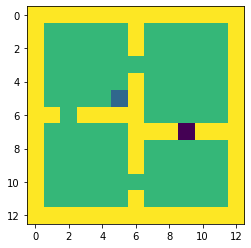

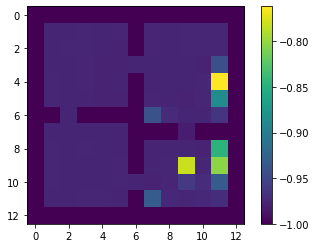

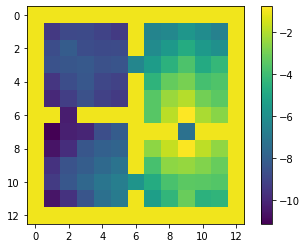

In [57]:
import matplotlib.pyplot as plt
import torch

device = torch.device('cuda')

state = env.render()
plt.imshow(state.reshape((13, 13)))
plt.figure()
reward = np.zeros((13, 13))
value = np.zeros((13, 13))
for i in range(13):
    for j in range(13):
        is_wall = env.occupancy[i, j] == 1
        if is_wall:
            reward[i, j] = -1
            value[i, j] = -1
        else:
            state_idx = env.tostate[(i, j)]
            state = env.reset(state_idx)
            state = torch.from_numpy(state).reshape(1, 169).to(device).float()
            phi = aps1.phi(state)
            w = aps1.task
            v = aps1.critic.get_Q1(state, w).max(dim=1).values
            # print(phi.shape, w.shape)
            reward[i, j] = torch.einsum("bi,bi->b", phi, w).data.cpu().numpy()
            value[i, j] = v.data.cpu().numpy()

plt.imshow(reward)     
plt.colorbar()
# print(reward)
plt.figure()
plt.imshow(value)
plt.colorbar()

In [20]:
env.occupancy

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [ ]:
replay_buffer = aps.make_replay_buffer()
aps.learn(replay_buffer, step_size=int(5e5), batch_size=32, fine_tune=False)

 45%|████▍     | 223063/500000 [1:02:36<1:24:58, 54.32it/s]

In [7]:
ft_rp = aps.make_replay_buffer()
evaluations = aps.learn(
    ft_rp,
    step_size=int(2e5),
    learning_start=int(5e3),
    batch_size=32,
    fine_tune=True
)

  0%|          | 1000/200000 [00:00<00:24, 8149.58it/s]

====== Total T: 101 Episode Num: 1 Episode_Length T: 101 Return: -100.000 ======
====== Total T: 282 Episode Num: 2 Episode_Length T: 181 Return: -180.000 ======
====== Total T: 482 Episode Num: 3 Episode_Length T: 200 Return: -200.000 ======
====== Total T: 682 Episode Num: 4 Episode_Length T: 200 Return: -200.000 ======
====== Total T: 805 Episode Num: 5 Episode_Length T: 123 Return: -122.000 ======
====== Total T: 871 Episode Num: 6 Episode_Length T: 66 Return: -65.000 ======
---------------------------------------
Evaluation over 10 episodes: -6.300
---------------------------------------
====== Total T: 1070 Episode Num: 7 Episode_Length T: 199 Return: -198.000 ======
====== Total T: 1270 Episode Num: 8 Episode_Length T: 200 Return: -200.000 ======
====== Total T: 1324 Episode Num: 9 Episode_Length T: 54 Return: -53.000 ======
====== Total T: 1524 Episode Num: 10 Episode_Length T: 200 Return: -200.000 ======
====== Total T: 1629 Episode Num: 11 Episode_Length T: 105 Return: -104.0

  2%|▏         | 3000/200000 [00:00<00:24, 7966.24it/s]

---------------------------------------
Evaluation over 10 episodes: -6.900
---------------------------------------
====== Total T: 2045 Episode Num: 14 Episode_Length T: 200 Return: -200.000 ======
====== Total T: 2245 Episode Num: 15 Episode_Length T: 200 Return: -200.000 ======
====== Total T: 2267 Episode Num: 16 Episode_Length T: 22 Return: -21.000 ======
====== Total T: 2323 Episode Num: 17 Episode_Length T: 56 Return: -55.000 ======
====== Total T: 2500 Episode Num: 18 Episode_Length T: 177 Return: -176.000 ======
====== Total T: 2700 Episode Num: 19 Episode_Length T: 200 Return: -200.000 ======
====== Total T: 2900 Episode Num: 20 Episode_Length T: 200 Return: -200.000 ======
---------------------------------------
Evaluation over 10 episodes: -6.300
---------------------------------------
====== Total T: 3085 Episode Num: 21 Episode_Length T: 185 Return: -184.000 ======
====== Total T: 3246 Episode Num: 22 Episode_Length T: 161 Return: -160.000 ======
====== Total T: 3415 Epis

  2%|▎         | 5000/200000 [00:00<00:23, 8251.06it/s]

---------------------------------------
Evaluation over 10 episodes: -6.300
---------------------------------------
====== Total T: 4139 Episode Num: 30 Episode_Length T: 200 Return: -200.000 ======
====== Total T: 4198 Episode Num: 31 Episode_Length T: 59 Return: -58.000 ======
====== Total T: 4398 Episode Num: 32 Episode_Length T: 200 Return: -200.000 ======
====== Total T: 4413 Episode Num: 33 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 4613 Episode Num: 34 Episode_Length T: 200 Return: -200.000 ======
====== Total T: 4813 Episode Num: 35 Episode_Length T: 200 Return: -200.000 ======
---------------------------------------
Evaluation over 10 episodes: -3.900
---------------------------------------
====== Total T: 5004 Episode Num: 36 Episode_Length T: 191 Return: -190.000 ======


/home/mila/y/yiran.wang/.conda/envs/mujoco_env/lib/python3.7/site-packages/ipykernel_launcher.py:346: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


====== Total T: 5014 Episode Num: 37 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 5015 Episode Num: 38 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 5024 Episode Num: 39 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 5032 Episode Num: 40 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 5037 Episode Num: 41 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 5040 Episode Num: 42 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 5045 Episode Num: 43 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 5051 Episode Num: 44 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 5060 Episode Num: 45 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 5066 Episode Num: 46 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 5071 Episode Num: 47 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 5082 Episode Num: 48 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 5089 Episode Num: 49 Episode_Lengt

  3%|▎         | 5835/200000 [00:06<07:26, 435.09it/s] 

====== Total T: 5811 Episode Num: 164 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 5816 Episode Num: 165 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 5823 Episode Num: 166 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 5827 Episode Num: 167 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 5832 Episode Num: 168 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 5834 Episode Num: 169 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 5836 Episode Num: 170 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 5841 Episode Num: 171 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 5843 Episode Num: 172 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 5847 Episode Num: 173 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 5850 Episode Num: 174 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 5856 Episode Num: 175 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 5861 Episode Num: 176 E

  3%|▎         | 6391/200000 [00:10<11:09, 289.05it/s]

====== Total T: 6369 Episode Num: 247 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 6374 Episode Num: 248 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 6381 Episode Num: 249 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 6386 Episode Num: 250 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 6397 Episode Num: 251 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 6401 Episode Num: 252 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 6408 Episode Num: 253 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 6415 Episode Num: 254 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 6421 Episode Num: 255 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 6429 Episode Num: 256 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 6441 Episode Num: 257 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 6443 Episode Num: 258 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 6447 Episode Num: 25

  3%|▎         | 6770/200000 [00:13<13:25, 239.91it/s]

====== Total T: 6772 Episode Num: 308 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 6783 Episode Num: 309 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 6788 Episode Num: 310 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 6794 Episode Num: 311 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 6801 Episode Num: 312 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 6806 Episode Num: 313 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 6815 Episode Num: 314 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 6821 Episode Num: 315 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 6825 Episode Num: 316 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 6832 Episode Num: 317 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 6834 Episode Num: 318 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 6842 Episode Num: 319 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 6850 Episode Num: 320 

  4%|▎         | 7033/200000 [00:15<15:02, 213.91it/s]

====== Total T: 7036 Episode Num: 345 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 7049 Episode Num: 346 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 7053 Episode Num: 347 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 7063 Episode Num: 348 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 7066 Episode Num: 349 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 7079 Episode Num: 350 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 7087 Episode Num: 351 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 7095 Episode Num: 352 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 7097 Episode Num: 353 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 7105 Episode Num: 354 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 7110 Episode Num: 355 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 7115 Episode Num: 356 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 7123 Episode Num:

  4%|▎         | 7218/200000 [00:17<16:07, 199.29it/s]

====== Total T: 7219 Episode Num: 370 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 7225 Episode Num: 371 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 7235 Episode Num: 372 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 7244 Episode Num: 373 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 7255 Episode Num: 374 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 7259 Episode Num: 375 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 7263 Episode Num: 376 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 7266 Episode Num: 377 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 7275 Episode Num: 378 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 7280 Episode Num: 379 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 7288 Episode Num: 380 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 7293 Episode Num: 381 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 7298 Episode Num: 382

  4%|▎         | 7350/200000 [00:18<16:59, 188.95it/s]


====== Total T: 7348 Episode Num: 392 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 7352 Episode Num: 393 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 7358 Episode Num: 394 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 7366 Episode Num: 395 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 7368 Episode Num: 396 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 7372 Episode Num: 397 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 7379 Episode Num: 398 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 7389 Episode Num: 399 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 7401 Episode Num: 400 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 7407 Episode Num: 401 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 7413 Episode Num: 402 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 7414 Episode Num: 403 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 7421 Episode Num: 404

  4%|▎         | 7446/200000 [00:18<17:43, 181.09it/s]

====== Total T: 7435 Episode Num: 406 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 7439 Episode Num: 407 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 7451 Episode Num: 408 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 7459 Episode Num: 409 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 7469 Episode Num: 410 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 7475 Episode Num: 411 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 7484 Episode Num: 412 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 7493 Episode Num: 413 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 7495 Episode Num: 414 Episode_Length T: 2 Return: -1.000 ======


  4%|▍         | 7517/200000 [00:19<18:20, 174.95it/s]

====== Total T: 7500 Episode Num: 415 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 7504 Episode Num: 416 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 7512 Episode Num: 417 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 7524 Episode Num: 418 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 7528 Episode Num: 419 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 7529 Episode Num: 420 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 7541 Episode Num: 421 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 7545 Episode Num: 422 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 7547 Episode Num: 423 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 7555 Episode Num: 424 Episode_Length T: 8 Return: -7.000 ======


  4%|▍         | 7571/200000 [00:19<18:50, 170.15it/s]

====== Total T: 7565 Episode Num: 425 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 7568 Episode Num: 426 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 7580 Episode Num: 427 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 7583 Episode Num: 428 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 7590 Episode Num: 429 Episode_Length T: 7 Return: -6.000 ======


  4%|▍         | 7613/200000 [00:20<19:17, 166.22it/s]

====== Total T: 7595 Episode Num: 430 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 7600 Episode Num: 431 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 7603 Episode Num: 432 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 7612 Episode Num: 433 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 7616 Episode Num: 434 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 7618 Episode Num: 435 Episode_Length T: 2 Return: -1.000 ======


  4%|▍         | 7647/200000 [00:20<19:47, 162.01it/s]

====== Total T: 7629 Episode Num: 436 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 7634 Episode Num: 437 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 7639 Episode Num: 438 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 7642 Episode Num: 439 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 7645 Episode Num: 440 Episode_Length T: 3 Return: -2.000 ======


  4%|▍         | 7675/200000 [00:20<20:14, 158.29it/s]

====== Total T: 7657 Episode Num: 441 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 7665 Episode Num: 442 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 7672 Episode Num: 443 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 7677 Episode Num: 444 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 7683 Episode Num: 445 Episode_Length T: 6 Return: -5.000 ======


  4%|▍         | 7698/200000 [00:20<20:36, 155.56it/s]

====== Total T: 7687 Episode Num: 446 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 7688 Episode Num: 447 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 7695 Episode Num: 448 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 7701 Episode Num: 449 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 7710 Episode Num: 450 Episode_Length T: 9 Return: -8.000 ======


  4%|▍         | 7738/200000 [00:20<21:18, 150.33it/s]

====== Total T: 7720 Episode Num: 451 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 7725 Episode Num: 452 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 7729 Episode Num: 453 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 7740 Episode Num: 454 Episode_Length T: 11 Return: -10.000 ======


  4%|▍         | 7771/200000 [00:21<21:55, 146.08it/s]

====== Total T: 7750 Episode Num: 455 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 7755 Episode Num: 456 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 7760 Episode Num: 457 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 7766 Episode Num: 458 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 7776 Episode Num: 459 Episode_Length T: 10 Return: -9.000 ======


  4%|▍         | 7802/200000 [00:21<22:34, 141.85it/s]

====== Total T: 7783 Episode Num: 460 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 7791 Episode Num: 461 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 7797 Episode Num: 462 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 7803 Episode Num: 463 Episode_Length T: 6 Return: -5.000 ======


  4%|▍         | 7832/200000 [00:21<23:03, 138.86it/s]

====== Total T: 7812 Episode Num: 464 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 7820 Episode Num: 465 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 7824 Episode Num: 466 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 7826 Episode Num: 467 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 7828 Episode Num: 468 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 7833 Episode Num: 469 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 7834 Episode Num: 470 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 7838 Episode Num: 471 Episode_Length T: 4 Return: -3.000 ======


  4%|▍         | 7860/200000 [00:21<23:25, 136.72it/s]

====== Total T: 7841 Episode Num: 472 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 7843 Episode Num: 473 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 7853 Episode Num: 474 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 7861 Episode Num: 475 Episode_Length T: 8 Return: -7.000 ======


  4%|▍         | 7890/200000 [00:22<23:27, 136.45it/s]

====== Total T: 7869 Episode Num: 476 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 7870 Episode Num: 477 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 7880 Episode Num: 478 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 7888 Episode Num: 479 Episode_Length T: 8 Return: -7.000 ======


  4%|▍         | 7919/200000 [00:22<23:32, 135.95it/s]

====== Total T: 7897 Episode Num: 480 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 7905 Episode Num: 481 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 7914 Episode Num: 482 Episode_Length T: 9 Return: -8.000 ======


  4%|▍         | 7947/200000 [00:22<23:57, 133.59it/s]

====== Total T: 7924 Episode Num: 483 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 7929 Episode Num: 484 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 7943 Episode Num: 485 Episode_Length T: 14 Return: -13.000 ======


  4%|▍         | 7975/200000 [00:22<23:59, 133.38it/s]

====== Total T: 7957 Episode Num: 486 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 7959 Episode Num: 487 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 7963 Episode Num: 488 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 7971 Episode Num: 489 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 7977 Episode Num: 490 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 7984 Episode Num: 491 Episode_Length T: 7 Return: -6.000 ======


  4%|▍         | 8003/200000 [00:22<29:00, 110.34it/s]

====== Total T: 7989 Episode Num: 492 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 7990 Episode Num: 493 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 7992 Episode Num: 494 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 7994 Episode Num: 495 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 7997 Episode Num: 496 Episode_Length T: 3 Return: -2.000 ======
---------------------------------------
Evaluation over 10 episodes: -8.100
---------------------------------------


  4%|▍         | 8030/200000 [00:23<26:38, 120.09it/s]

====== Total T: 8005 Episode Num: 497 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 8013 Episode Num: 498 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 8018 Episode Num: 499 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 8029 Episode Num: 500 Episode_Length T: 11 Return: -10.000 ======


  4%|▍         | 8057/200000 [00:23<25:17, 126.48it/s]

====== Total T: 8034 Episode Num: 501 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 8039 Episode Num: 502 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 8041 Episode Num: 503 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 8048 Episode Num: 504 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 8059 Episode Num: 505 Episode_Length T: 11 Return: -10.000 ======


  4%|▍         | 8085/200000 [00:23<24:51, 128.70it/s]

====== Total T: 8072 Episode Num: 506 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 8082 Episode Num: 507 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 8093 Episode Num: 508 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 8098 Episode Num: 509 Episode_Length T: 5 Return: -4.000 ======


  4%|▍         | 8127/200000 [00:23<24:11, 132.23it/s]

====== Total T: 8103 Episode Num: 510 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 8107 Episode Num: 511 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 8112 Episode Num: 512 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 8122 Episode Num: 513 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 8129 Episode Num: 514 Episode_Length T: 7 Return: -6.000 ======


  4%|▍         | 8155/200000 [00:24<24:14, 131.89it/s]

====== Total T: 8138 Episode Num: 515 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 8148 Episode Num: 516 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 8158 Episode Num: 517 Episode_Length T: 10 Return: -9.000 ======


  4%|▍         | 8183/200000 [00:24<24:07, 132.55it/s]

====== Total T: 8169 Episode Num: 518 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 8175 Episode Num: 519 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 8185 Episode Num: 520 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 8191 Episode Num: 521 Episode_Length T: 6 Return: -5.000 ======


  4%|▍         | 8225/200000 [00:24<23:52, 133.86it/s]

====== Total T: 8203 Episode Num: 522 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 8211 Episode Num: 523 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 8220 Episode Num: 524 Episode_Length T: 9 Return: -8.000 ======


  4%|▍         | 8255/200000 [00:24<23:37, 135.27it/s]

====== Total T: 8230 Episode Num: 525 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 8242 Episode Num: 526 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 8255 Episode Num: 527 Episode_Length T: 13 Return: -12.000 ======


  4%|▍         | 8285/200000 [00:25<23:35, 135.41it/s]

====== Total T: 8259 Episode Num: 528 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 8269 Episode Num: 529 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 8279 Episode Num: 530 Episode_Length T: 10 Return: -9.000 ======


  4%|▍         | 8313/200000 [00:25<23:31, 135.84it/s]

====== Total T: 8286 Episode Num: 531 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 8289 Episode Num: 532 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 8290 Episode Num: 533 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 8296 Episode Num: 534 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 8301 Episode Num: 535 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 8311 Episode Num: 536 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 8312 Episode Num: 537 Episode_Length T: 1 Return: 0.000 ======


  4%|▍         | 8341/200000 [00:25<23:36, 135.30it/s]

====== Total T: 8316 Episode Num: 538 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 8326 Episode Num: 539 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 8331 Episode Num: 540 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 8335 Episode Num: 541 Episode_Length T: 4 Return: -3.000 ======


  4%|▍         | 8370/200000 [00:25<23:37, 135.14it/s]

====== Total T: 8344 Episode Num: 542 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 8348 Episode Num: 543 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 8354 Episode Num: 544 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 8364 Episode Num: 545 Episode_Length T: 10 Return: -9.000 ======


  4%|▍         | 8384/200000 [00:25<23:45, 134.43it/s]

====== Total T: 8371 Episode Num: 546 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 8375 Episode Num: 547 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 8381 Episode Num: 548 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 8388 Episode Num: 549 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 8394 Episode Num: 550 Episode_Length T: 6 Return: -5.000 ======


  4%|▍         | 8426/200000 [00:26<24:17, 131.48it/s]

====== Total T: 8406 Episode Num: 551 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 8418 Episode Num: 552 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 8428 Episode Num: 553 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 8431 Episode Num: 554 Episode_Length T: 3 Return: -2.000 ======


  4%|▍         | 8468/200000 [00:26<24:14, 131.69it/s]

====== Total T: 8443 Episode Num: 555 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 8447 Episode Num: 556 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 8450 Episode Num: 557 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 8454 Episode Num: 558 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 8468 Episode Num: 559 Episode_Length T: 14 Return: -13.000 ======


  4%|▍         | 8496/200000 [00:26<24:23, 130.85it/s]

====== Total T: 8477 Episode Num: 560 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 8482 Episode Num: 561 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 8483 Episode Num: 562 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 8494 Episode Num: 563 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 8496 Episode Num: 564 Episode_Length T: 2 Return: -1.000 ======


  4%|▍         | 8525/200000 [00:26<23:56, 133.26it/s]

====== Total T: 8509 Episode Num: 565 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 8521 Episode Num: 566 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 8532 Episode Num: 567 Episode_Length T: 11 Return: -10.000 ======


  4%|▍         | 8555/200000 [00:27<23:48, 134.00it/s]

====== Total T: 8540 Episode Num: 568 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 8543 Episode Num: 569 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 8548 Episode Num: 570 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 8557 Episode Num: 571 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 8563 Episode Num: 572 Episode_Length T: 6 Return: -5.000 ======


  4%|▍         | 8583/200000 [00:27<23:45, 134.24it/s]

====== Total T: 8568 Episode Num: 573 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 8577 Episode Num: 574 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 8586 Episode Num: 575 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 8591 Episode Num: 576 Episode_Length T: 5 Return: -4.000 ======


  4%|▍         | 8625/200000 [00:27<23:38, 134.94it/s]

====== Total T: 8599 Episode Num: 577 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 8604 Episode Num: 578 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 8615 Episode Num: 579 Episode_Length T: 11 Return: -10.000 ======


  4%|▍         | 8653/200000 [00:27<23:25, 136.15it/s]

====== Total T: 8626 Episode Num: 580 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 8632 Episode Num: 581 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 8637 Episode Num: 582 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 8642 Episode Num: 583 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 8646 Episode Num: 584 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 8650 Episode Num: 585 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 8652 Episode Num: 586 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 8653 Episode Num: 587 Episode_Length T: 1 Return: 0.000 ======


  4%|▍         | 8681/200000 [00:28<24:35, 129.68it/s]

====== Total T: 8657 Episode Num: 588 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 8661 Episode Num: 589 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 8662 Episode Num: 590 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 8668 Episode Num: 591 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 8676 Episode Num: 592 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 8679 Episode Num: 593 Episode_Length T: 3 Return: -2.000 ======


  4%|▍         | 8695/200000 [00:28<24:58, 127.62it/s]

====== Total T: 8683 Episode Num: 594 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 8691 Episode Num: 595 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 8695 Episode Num: 596 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 8706 Episode Num: 597 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 8708 Episode Num: 598 Episode_Length T: 2 Return: -1.000 ======


  4%|▍         | 8748/200000 [00:28<24:52, 128.18it/s]

====== Total T: 8723 Episode Num: 599 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 8733 Episode Num: 600 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 8739 Episode Num: 601 Episode_Length T: 6 Return: -5.000 ======


  4%|▍         | 8774/200000 [00:28<24:58, 127.63it/s]

====== Total T: 8751 Episode Num: 602 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 8757 Episode Num: 603 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 8770 Episode Num: 604 Episode_Length T: 13 Return: -12.000 ======


  4%|▍         | 8800/200000 [00:28<25:13, 126.29it/s]

====== Total T: 8778 Episode Num: 605 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 8784 Episode Num: 606 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 8789 Episode Num: 607 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 8798 Episode Num: 608 Episode_Length T: 9 Return: -8.000 ======


  4%|▍         | 8827/200000 [00:29<25:14, 126.20it/s]

====== Total T: 8804 Episode Num: 609 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 8806 Episode Num: 610 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 8812 Episode Num: 611 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 8821 Episode Num: 612 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 8825 Episode Num: 613 Episode_Length T: 4 Return: -3.000 ======


  4%|▍         | 8854/200000 [00:29<24:59, 127.43it/s]

====== Total T: 8831 Episode Num: 614 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 8838 Episode Num: 615 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 8841 Episode Num: 616 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 8844 Episode Num: 617 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 8848 Episode Num: 618 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 8851 Episode Num: 619 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 8855 Episode Num: 620 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 8856 Episode Num: 621 Episode_Length T: 1 Return: 0.000 ======


  4%|▍         | 8880/200000 [00:29<25:16, 126.05it/s]

====== Total T: 8859 Episode Num: 622 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 8864 Episode Num: 623 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 8873 Episode Num: 624 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 8876 Episode Num: 625 Episode_Length T: 3 Return: -2.000 ======


  4%|▍         | 8907/200000 [00:29<25:01, 127.31it/s]

====== Total T: 8885 Episode Num: 626 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 8886 Episode Num: 627 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 8891 Episode Num: 628 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 8895 Episode Num: 629 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 8906 Episode Num: 630 Episode_Length T: 11 Return: -10.000 ======


  4%|▍         | 8934/200000 [00:30<24:28, 130.11it/s]

====== Total T: 8912 Episode Num: 631 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 8922 Episode Num: 632 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 8935 Episode Num: 633 Episode_Length T: 13 Return: -12.000 ======


  4%|▍         | 8962/200000 [00:30<24:32, 129.75it/s]

====== Total T: 8942 Episode Num: 634 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 8951 Episode Num: 635 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 8967 Episode Num: 636 Episode_Length T: 16 Return: -15.000 ======


  4%|▍         | 8988/200000 [00:30<24:50, 128.17it/s]

====== Total T: 8971 Episode Num: 637 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 8981 Episode Num: 638 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 8988 Episode Num: 639 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 8995 Episode Num: 640 Episode_Length T: 7 Return: -6.000 ======


  5%|▍         | 9015/200000 [00:30<27:20, 116.40it/s]

---------------------------------------
Evaluation over 10 episodes: -5.700
---------------------------------------
====== Total T: 9000 Episode Num: 641 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 9010 Episode Num: 642 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 9016 Episode Num: 643 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 9019 Episode Num: 644 Episode_Length T: 3 Return: -2.000 ======


  5%|▍         | 9042/200000 [00:30<26:02, 122.18it/s]

====== Total T: 9028 Episode Num: 645 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 9039 Episode Num: 646 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 9044 Episode Num: 647 Episode_Length T: 5 Return: -4.000 ======


  5%|▍         | 9082/200000 [00:31<24:58, 127.44it/s]

====== Total T: 9057 Episode Num: 648 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 9069 Episode Num: 649 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 9073 Episode Num: 650 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 9080 Episode Num: 651 Episode_Length T: 7 Return: -6.000 ======


  5%|▍         | 9110/200000 [00:31<24:23, 130.45it/s]

====== Total T: 9087 Episode Num: 652 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 9097 Episode Num: 653 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 9109 Episode Num: 654 Episode_Length T: 12 Return: -11.000 ======


  5%|▍         | 9138/200000 [00:31<24:18, 130.88it/s]

====== Total T: 9117 Episode Num: 655 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 9120 Episode Num: 656 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 9123 Episode Num: 657 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 9129 Episode Num: 658 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 9137 Episode Num: 659 Episode_Length T: 8 Return: -7.000 ======


  5%|▍         | 9166/200000 [00:31<24:19, 130.79it/s]

====== Total T: 9148 Episode Num: 660 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 9151 Episode Num: 661 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 9159 Episode Num: 662 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 9166 Episode Num: 663 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 9172 Episode Num: 664 Episode_Length T: 6 Return: -5.000 ======


  5%|▍         | 9195/200000 [00:32<24:02, 132.28it/s]

====== Total T: 9177 Episode Num: 665 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 9180 Episode Num: 666 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 9190 Episode Num: 667 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 9192 Episode Num: 668 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 9201 Episode Num: 669 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 9204 Episode Num: 670 Episode_Length T: 3 Return: -2.000 ======


  5%|▍         | 9225/200000 [00:32<23:38, 134.48it/s]

====== Total T: 9210 Episode Num: 671 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 9211 Episode Num: 672 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 9222 Episode Num: 673 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 9226 Episode Num: 674 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 9232 Episode Num: 675 Episode_Length T: 6 Return: -5.000 ======


  5%|▍         | 9267/200000 [00:32<23:17, 136.51it/s]

====== Total T: 9246 Episode Num: 676 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 9251 Episode Num: 677 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 9260 Episode Num: 678 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 9266 Episode Num: 679 Episode_Length T: 6 Return: -5.000 ======


  5%|▍         | 9295/200000 [00:32<23:33, 134.96it/s]

====== Total T: 9278 Episode Num: 680 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 9287 Episode Num: 681 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 9292 Episode Num: 682 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 9296 Episode Num: 683 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 9297 Episode Num: 684 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 9302 Episode Num: 685 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 9304 Episode Num: 686 Episode_Length T: 2 Return: -1.000 ======


  5%|▍         | 9339/200000 [00:33<23:02, 137.91it/s]

====== Total T: 9312 Episode Num: 687 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 9324 Episode Num: 688 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 9336 Episode Num: 689 Episode_Length T: 12 Return: -11.000 ======
====== Total T: 9338 Episode Num: 690 Episode_Length T: 2 Return: -1.000 ======


  5%|▍         | 9367/200000 [00:33<23:19, 136.22it/s]

====== Total T: 9344 Episode Num: 691 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 9350 Episode Num: 692 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 9357 Episode Num: 693 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 9366 Episode Num: 694 Episode_Length T: 9 Return: -8.000 ======


  5%|▍         | 9395/200000 [00:33<23:28, 135.34it/s]

====== Total T: 9375 Episode Num: 695 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 9386 Episode Num: 696 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 9389 Episode Num: 697 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 9394 Episode Num: 698 Episode_Length T: 5 Return: -4.000 ======


  5%|▍         | 9425/200000 [00:33<23:20, 136.12it/s]

====== Total T: 9403 Episode Num: 699 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 9406 Episode Num: 700 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 9407 Episode Num: 701 Episode_Length T: 1 Return: 0.000 ======
====== Total T: 9412 Episode Num: 702 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 9423 Episode Num: 703 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 9429 Episode Num: 704 Episode_Length T: 6 Return: -5.000 ======


  5%|▍         | 9455/200000 [00:33<23:02, 137.79it/s]

====== Total T: 9439 Episode Num: 705 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 9449 Episode Num: 706 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 9464 Episode Num: 707 Episode_Length T: 15 Return: -14.000 ======


  5%|▍         | 9498/200000 [00:34<23:01, 137.89it/s]

====== Total T: 9472 Episode Num: 708 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 9477 Episode Num: 709 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 9483 Episode Num: 710 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 9487 Episode Num: 711 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 9498 Episode Num: 712 Episode_Length T: 11 Return: -10.000 ======


  5%|▍         | 9526/200000 [00:34<24:09, 131.39it/s]

====== Total T: 9503 Episode Num: 713 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 9518 Episode Num: 714 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 9525 Episode Num: 715 Episode_Length T: 7 Return: -6.000 ======


  5%|▍         | 9555/200000 [00:34<24:00, 132.17it/s]

====== Total T: 9535 Episode Num: 716 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 9545 Episode Num: 717 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 9552 Episode Num: 718 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 9556 Episode Num: 719 Episode_Length T: 4 Return: -3.000 ======


  5%|▍         | 9583/200000 [00:34<23:27, 135.30it/s]

====== Total T: 9564 Episode Num: 720 Episode_Length T: 8 Return: -7.000 ======
====== Total T: 9581 Episode Num: 721 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 9591 Episode Num: 722 Episode_Length T: 10 Return: -9.000 ======


  5%|▍         | 9611/200000 [00:35<23:40, 134.04it/s]

====== Total T: 9598 Episode Num: 723 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 9603 Episode Num: 724 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 9619 Episode Num: 725 Episode_Length T: 16 Return: -15.000 ======


  5%|▍         | 9640/200000 [00:35<23:35, 134.46it/s]

====== Total T: 9626 Episode Num: 726 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 9631 Episode Num: 727 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 9638 Episode Num: 728 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 9640 Episode Num: 729 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 9645 Episode Num: 730 Episode_Length T: 5 Return: -4.000 ======


  5%|▍         | 9670/200000 [00:35<23:25, 135.41it/s]

====== Total T: 9656 Episode Num: 731 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 9658 Episode Num: 732 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 9669 Episode Num: 733 Episode_Length T: 11 Return: -10.000 ======
====== Total T: 9681 Episode Num: 734 Episode_Length T: 12 Return: -11.000 ======


  5%|▍         | 9715/200000 [00:35<23:08, 137.00it/s]

====== Total T: 9698 Episode Num: 735 Episode_Length T: 17 Return: -16.000 ======
====== Total T: 9712 Episode Num: 736 Episode_Length T: 14 Return: -13.000 ======
====== Total T: 9724 Episode Num: 737 Episode_Length T: 12 Return: -11.000 ======


  5%|▍         | 9758/200000 [00:36<23:24, 135.40it/s]

====== Total T: 9734 Episode Num: 738 Episode_Length T: 10 Return: -9.000 ======
====== Total T: 9738 Episode Num: 739 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 9751 Episode Num: 740 Episode_Length T: 13 Return: -12.000 ======
====== Total T: 9755 Episode Num: 741 Episode_Length T: 4 Return: -3.000 ======


  5%|▍         | 9786/200000 [00:36<23:29, 135.00it/s]

====== Total T: 9760 Episode Num: 742 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 9764 Episode Num: 743 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 9766 Episode Num: 744 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 9771 Episode Num: 745 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 9783 Episode Num: 746 Episode_Length T: 12 Return: -11.000 ======


  5%|▍         | 9815/200000 [00:36<23:23, 135.55it/s]

====== Total T: 9789 Episode Num: 747 Episode_Length T: 6 Return: -5.000 ======
====== Total T: 9796 Episode Num: 748 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 9811 Episode Num: 749 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 9813 Episode Num: 750 Episode_Length T: 2 Return: -1.000 ======
====== Total T: 9814 Episode Num: 751 Episode_Length T: 1 Return: 0.000 ======


  5%|▍         | 9830/200000 [00:36<23:25, 135.35it/s]

====== Total T: 9817 Episode Num: 752 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 9820 Episode Num: 753 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 9829 Episode Num: 754 Episode_Length T: 9 Return: -8.000 ======
====== Total T: 9839 Episode Num: 755 Episode_Length T: 10 Return: -9.000 ======


  5%|▍         | 9873/200000 [00:37<23:26, 135.13it/s]

====== Total T: 9846 Episode Num: 756 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 9850 Episode Num: 757 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 9860 Episode Num: 758 Episode_Length T: 10 Return: -9.000 ======


  5%|▍         | 9898/200000 [00:37<11:56, 265.35it/s]

====== Total T: 9875 Episode Num: 759 Episode_Length T: 15 Return: -14.000 ======
====== Total T: 9879 Episode Num: 760 Episode_Length T: 4 Return: -3.000 ======
====== Total T: 9886 Episode Num: 761 Episode_Length T: 7 Return: -6.000 ======
====== Total T: 9889 Episode Num: 762 Episode_Length T: 3 Return: -2.000 ======
====== Total T: 9894 Episode Num: 763 Episode_Length T: 5 Return: -4.000 ======
====== Total T: 9896 Episode Num: 764 Episode_Length T: 2 Return: -1.000 ======


KeyboardInterrupt: 

Text(0.5, 1.0, 'aps fourrooms with changing init state, conv encoder, layout=4rooms')

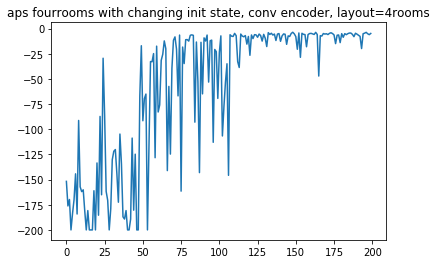

In [9]:
import matplotlib.pyplot as plt

plt.plot(evaluations)
plt.title('aps fourrooms with changing init state, conv encoder, layout=4rooms')

In [18]:
from fourrooms import FourRooms
g = [21, 28, 84, 91]
c = np.ones(104)*4
room1 = list(range(5)) + list(range(10,15)) + list(range(20,25)) + list(range(31,36)) +list(range(41,46))
room2 = list(range(5,10)) + list(range(15,20)) + list(range(26,31)) + list(range(36,41)) + list(range(46,51)) + list(range(52,57))
room3 = list(range(57,62)) + list(range(63,68)) + list(range(73,78)) + list(range(83,88)) + list(range(94,99))
connect = [25, 51, 62, 88]
c[room1] = 1
c[room2] = 2
c[room3] = 3
c[connect] = [-1, -1, -1, -1]

device = torch.device('cuda')
env = FourRooms(layout='4rooms', config=2)
phi_all = np.zeros((104, 4))
for i in range(104):
    state = env.reset(init=i)
    state = torch.from_numpy(state).reshape(1, 13, 13).unsqueeze(0).float().to(device)
    # print(state.shape, aps.phi)
    out = aps.encoder(state)
    out = aps.phi(out)
    phi = out.detach().cpu().numpy()
    phi_all[i,:] = phi.flatten()


Text(0, 0.5, 'second principle component')

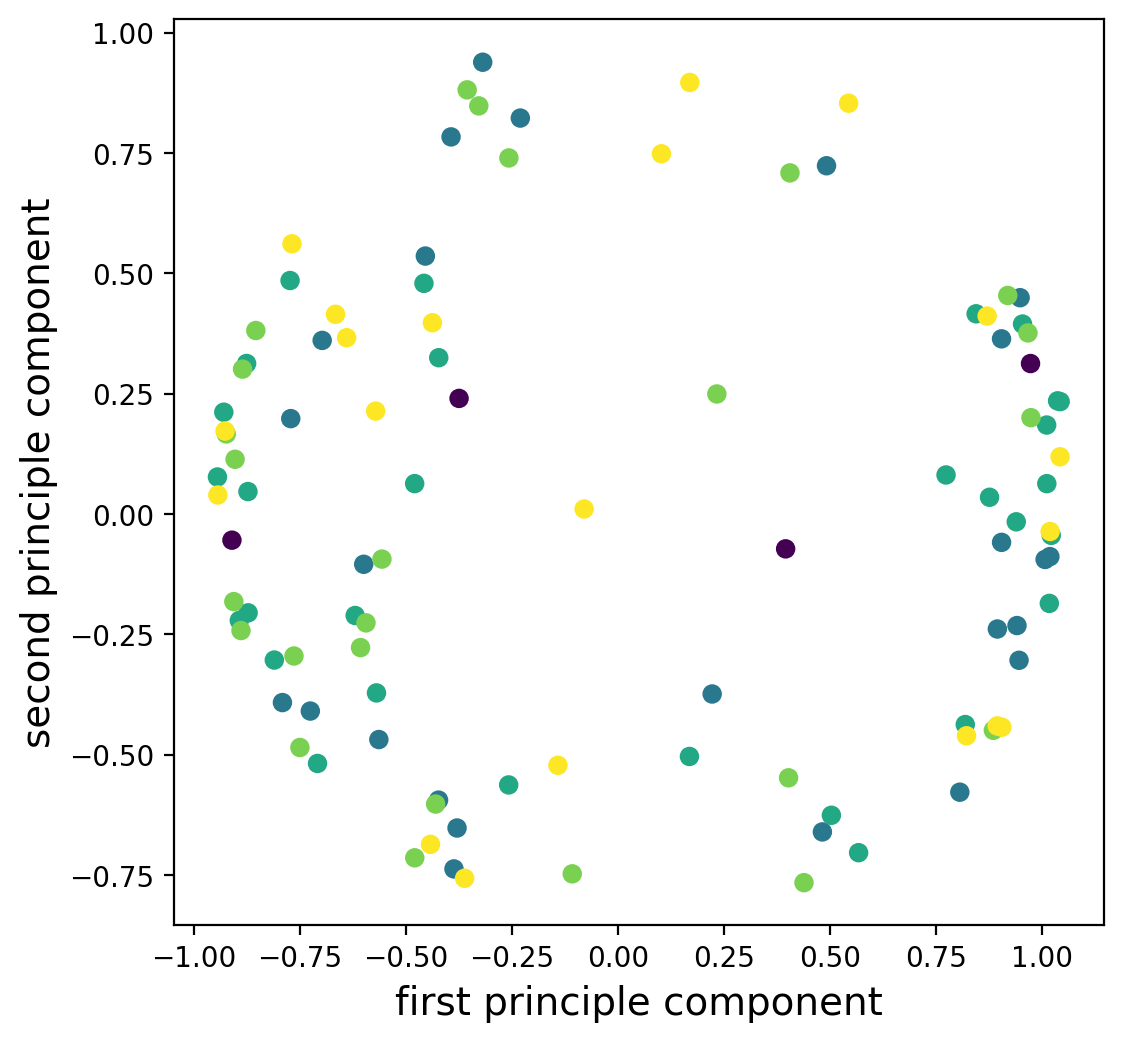

In [21]:
from sklearn.decomposition import PCA
plt.figure(figsize=(6,6),dpi=200)
pca = PCA(n_components=2)
k = pca.fit_transform(phi_all)
plt.scatter(k[:,0],k[:,1], c=c)
# plt.color_bar()
plt.xlabel('first principle component', fontsize=14)
plt.ylabel('second principle component', fontsize=14)


Text(0.5, 1.0, 'aps fourrooms, conv encoder, layout=4rooms')

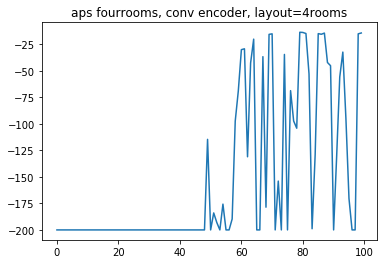

In [17]:
import matplotlib.pyplot as plt

plt.plot(evaluations)
plt.title('aps fourrooms, conv encoder, layout=4rooms')

Text(0.5, 1.0, 'aps fourrooms, conv encoder, layout=open')

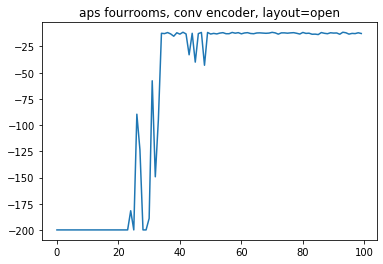

In [14]:
import matplotlib.pyplot as plt

plt.plot(evaluations)
plt.title('aps fourrooms, conv encoder, layout=open')

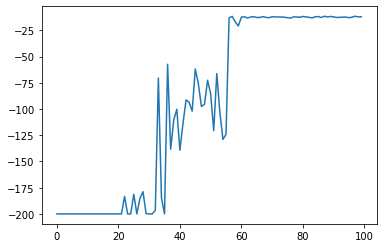

In [70]:
import matplotlib.pyplot as plt

plt.plot(evaluations, title='aps after pretraini')